In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import json
import os
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
from collections import defaultdict
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


In [2]:
class Conv(nn.Module):
    """Lightweight convolution block with optional activation"""
    def __init__(self, in_channels, out_channels, k=1, s=1, p=None, g=1, act=True):
        super().__init__()
        if p is None:
            p = k // 2
        self.conv = nn.Conv2d(in_channels, out_channels, k, s, p, groups=g, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU(inplace=True) if act else nn.Identity()
    
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class PyramidPooling(nn.Module):
    """Lightweight PSP module optimized for binary detection"""
    def __init__(self, in_channels, out_channels, pool_sizes=(1, 2, 3, 6)):
        super().__init__()
        self.pool_sizes = pool_sizes
        self.stages = nn.ModuleList()
        
        # Reduce channels per stage for efficiency
        stage_channels = out_channels // len(pool_sizes)
        
        for pool_size in pool_sizes:
            self.stages.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                Conv(in_channels, stage_channels, 1, act=True),
            ))
        
        # Final fusion layer
        total_channels = in_channels + len(pool_sizes) * stage_channels
        self.fusion = Conv(total_channels, out_channels, 1, act=True)
        
    def forward(self, x):
        h, w = x.shape[2:]
        pyramid_features = [x]  # Original feature
        
        for stage in self.stages:
            pooled = stage(x)
            upsampled = F.interpolate(pooled, size=(h, w), mode='bilinear', align_corners=False)
            pyramid_features.append(upsampled)
        
        # Concatenate all pyramid features
        combined = torch.cat(pyramid_features, dim=1)
        return self.fusion(combined)

class ChannelAttention(nn.Module):
    """Channel attention for focusing on important feature channels"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        b, c, _, _ = x.shape
        
        # Channel-wise statistics
        avg_pool = self.avg_pool(x).view(b, c)
        max_pool = self.max_pool(x).view(b, c)
        
        # Attention weights
        avg_out = self.fc(avg_pool)
        max_out = self.fc(max_pool)
        
        attention = self.sigmoid(avg_out + max_out).view(b, c, 1, 1)
        return x * attention

class SpatialAttention(nn.Module):
    """Spatial attention for focusing on important spatial locations"""
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = Conv(2, 1, kernel_size, p=kernel_size//2, act=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Channel-wise max and avg pooling
        max_pool = torch.max(x, dim=1, keepdim=True)[0]
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        
        # Concatenate and get spatial attention
        spatial_input = torch.cat([max_pool, avg_pool], dim=1)
        attention = self.sigmoid(self.conv(spatial_input))
        
        return x * attention

class CBAM(nn.Module):
    """Convolutional Block Attention Module"""
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)
        
    def forward(self, x):
        # Apply channel attention first, then spatial attention
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

In [3]:
class BugDetectionDataset(Dataset):
    def __init__(self, annotation_file, image_dir, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms
        
        # Load COCO format annotations
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)
        
        # Create image id to filename mapping
        self.images = {img['id']: img for img in self.coco_data['images']}
        
        # Group annotations by image
        self.annotations = defaultdict(list)
        for ann in self.coco_data['annotations']:
            self.annotations[ann['image_id']].append(ann)
        
        # Get list of image IDs that have annotations
        self.image_ids = list(self.annotations.keys())
        
        print(f"Loaded {len(self.image_ids)} images with annotations")
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.images[image_id]
        
        # Load image
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(image_path).convert('RGB')
        
        # Convert to tensor first
        if self.transforms:
            image = self.transforms(image)
        else:
            image = transforms.ToTensor()(image)
        
        # Get annotations for this image
        annotations = self.annotations[image_id]
        
        boxes = []
        labels = []
        areas = []
        
        for ann in annotations:
            # Convert COCO bbox format [x, y, width, height] to [x1, y1, x2, y2]
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(1)  # Binary detection - all bugs are class 1
            areas.append(ann['area'])
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        
        # Create target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([image_id]),
            'area': areas,
            'iscrowd': torch.zeros((len(annotations),), dtype=torch.int64)
        }
        
        return image, target

def collate_fn(batch):
    """Custom collate function for DataLoader"""
    return tuple(zip(*batch))

# Data transforms
def get_transforms(train=True):
    transforms_list = [transforms.ToTensor()]
    
    if train:
        # Add simple training augmentations that work with detection
        transforms_list.insert(0, transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1))
    
    return transforms.Compose(transforms_list)

# Data loading function
def create_dataloaders(data_dir, batch_size=4, num_workers=0):
    """Create train and validation dataloaders"""
    
    # Dataset paths
    train_ann_file = os.path.join(data_dir, 'dataset_train.json')
    val_ann_file = os.path.join(data_dir, 'dataset_val.json')
    
    # Verify files exist
    if not os.path.exists(train_ann_file):
        raise FileNotFoundError(f"Training annotation file not found: {train_ann_file}")
    if not os.path.exists(val_ann_file):
        raise FileNotFoundError(f"Validation annotation file not found: {val_ann_file}")
    
    try:
        # Create datasets
        train_dataset = BugDetectionDataset(
            annotation_file=train_ann_file,
            image_dir=data_dir,
            transforms=get_transforms(train=True)
        )
        
        val_dataset = BugDetectionDataset(
            annotation_file=val_ann_file,
            image_dir=data_dir,
            transforms=get_transforms(train=False)
        )
        
        print(f"Created datasets successfully:")
        print(f"  Training: {len(train_dataset)} samples")
        print(f"  Validation: {len(val_dataset)} samples")
        
        # Create data loaders with error handling
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=num_workers,
            collate_fn=collate_fn,
            pin_memory=torch.cuda.is_available() and num_workers > 0,
            persistent_workers=num_workers > 0
        )
        
        val_loader = DataLoader(
            val_dataset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=num_workers,
            collate_fn=collate_fn,
            pin_memory=torch.cuda.is_available() and num_workers > 0,
            persistent_workers=num_workers > 0
        )
        
        print(f"Created dataloaders with num_workers={num_workers}")
        
        return train_loader, val_loader, len(train_dataset), len(val_dataset)
        
    except Exception as e:
        print(f"Error creating dataloaders: {str(e)}")
        print("Trying with num_workers=0...")
        
        # Fallback to single-threaded loading
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=0,
            collate_fn=collate_fn
        )
        
        val_loader = DataLoader(
            val_dataset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=0,
            collate_fn=collate_fn
        )
        
        print("Successfully created single-threaded dataloaders")
        return train_loader, val_loader, len(train_dataset), len(val_dataset)

In [4]:
class EnhancedFasterRCNN(nn.Module):
    """Enhanced Faster R-CNN with PyramidPooling and CBAM attention"""
    def __init__(self, num_classes=2, pretrained=True):  # 2 classes: background + bug
        super().__init__()
        
        # Load pretrained Faster R-CNN with ResNet50 backbone
        self.model = fasterrcnn_resnet50_fpn(pretrained=pretrained)
        
        # Get the number of input features for the classifier
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        
        # Replace the pre-trained head with a new one for binary classification
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        
        # Add custom modules to FPN features - simplified approach
        # FPN typically outputs 256 channels
        fpn_channels = 256
        enhanced_channels = 128  # Reduced for lightweight deployment
        
        # Store enhancement modules but don't use hooks (which can cause issues)
        self.pyramid_pooling = PyramidPooling(fpn_channels, enhanced_channels)
        self.cbam = CBAM(enhanced_channels, reduction=8)
        self.feature_fusion = Conv(enhanced_channels, fpn_channels, 1, act=True)
        
        # Note: For now, we'll use the base model without custom enhancements
        # to ensure training stability. Custom modules can be integrated later.
    
    def forward(self, images, targets=None):
        # Use the base model directly for now
        return self.model(images, targets)
    
    def enhance_features(self, features):
        """Method to enhance features when needed (currently not used)"""
        enhanced = self.pyramid_pooling(features)
        enhanced = self.cbam(enhanced)
        enhanced = self.feature_fusion(enhanced)
        return enhanced

def create_model(num_classes=2, pretrained=True):
    """Create and return the enhanced model"""
    model = EnhancedFasterRCNN(num_classes=num_classes, pretrained=pretrained)
    return model

def count_parameters(model):
    """Count total and trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    return total_params, trainable_params

def get_model_size(model):
    """Get model size in MB"""
    param_size = 0
    buffer_size = 0
    
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

def freeze_backbone_layers(model, freeze_ratio=0.75):
    """Freeze a portion of the backbone layers (3/4 as requested)"""
    backbone_params = []
    
    # Get all backbone parameters
    for name, param in model.named_parameters():
        if 'backbone' in name:
            backbone_params.append((name, param))
    
    # Calculate how many layers to freeze
    num_to_freeze = int(len(backbone_params) * freeze_ratio)
    
    # Freeze the specified ratio of backbone parameters
    for i, (name, param) in enumerate(backbone_params):
        if i < num_to_freeze:
            param.requires_grad = False
            print(f"Frozen: {name}")
    
    print(f"Frozen {num_to_freeze}/{len(backbone_params)} backbone parameters ({freeze_ratio*100:.0f}%)")
    
    return model

In [5]:
# Configuration
CONFIG = {
    'data_dir': '/home/anuragaryal/coco/data',  # Update this path
    'batch_size': 4,
    'num_workers': 0,  # Set to 0 to disable multiprocessing
    'num_classes': 2,  # background + bug
    'learning_rate': 0.001,
    'num_epochs': 50,
    'freeze_ratio': 0.75,  # Freeze 3/4 of backbone as requested
    'save_dir': 'outputs',
    'model_name': 'enhanced_faster_rcnn_bug_detection'
}

# Create output directory
os.makedirs(CONFIG['save_dir'], exist_ok=True)

def instantiate_and_analyze_model():
    """Instantiate model and analyze its properties"""
    print("=" * 50)
    print("MODEL INSTANTIATION AND ANALYSIS")
    print("=" * 50)
    
    # Create model
    print("Creating Enhanced Faster R-CNN model...")
    model = create_model(num_classes=CONFIG['num_classes'], pretrained=True)
    
    # Freeze backbone layers
    print(f"\nFreezing {CONFIG['freeze_ratio']*100:.0f}% of backbone layers...")
    model = freeze_backbone_layers(model, freeze_ratio=CONFIG['freeze_ratio'])
    
    # Move to device
    model = model.to(device)
    
    # Count parameters
    total_params, trainable_params = count_parameters(model)
    frozen_params = total_params - trainable_params
    
    # Get model size
    model_size_mb = get_model_size(model)
    
    # Print analysis
    print("\n" + "=" * 50)
    print("MODEL ANALYSIS RESULTS")
    print("=" * 50)
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Frozen Parameters: {frozen_params:,}")
    print(f"Trainable Ratio: {(trainable_params/total_params)*100:.2f}%")
    print(f"Model Size: {model_size_mb:.2f} MB")
    print(f"Device: {device}")
    
    # Calculate estimated inference time and memory usage
    print(f"\nModel Configuration:")
    print(f"- Backbone: ResNet50 with FPN")
    print(f"- Custom Modules: PyramidPooling + CBAM Attention")
    print(f"- Detection Head: Binary Classification (Bug vs Background)")
    print(f"- Lightweight Design: Optimized for RPi deployment")
    
    # Save model analysis to CSV
    analysis_data = {
        'Metric': ['Total Parameters', 'Trainable Parameters', 'Frozen Parameters', 
                  'Trainable Ratio (%)', 'Model Size (MB)', 'Backbone Freeze Ratio (%)'],
        'Value': [total_params, trainable_params, frozen_params,
                 f"{(trainable_params/total_params)*100:.2f}", 
                 f"{model_size_mb:.2f}", f"{CONFIG['freeze_ratio']*100:.0f}"]
    }
    
    analysis_df = pd.DataFrame(analysis_data)
    analysis_df.to_csv(os.path.join(CONFIG['save_dir'], 'model_analysis.csv'), index=False)
    print(f"\nModel analysis saved to: {CONFIG['save_dir']}/model_analysis.csv")
    
    return model

def test_model_forward_pass(model):
    """Test model with dummy input to ensure everything works"""
    print("\n" + "=" * 50)
    print("TESTING MODEL FORWARD PASS")
    print("=" * 50)
    
    model.eval()
    
    # Create dummy input - Faster R-CNN expects list of 3D tensors [C, H, W]
    dummy_image = torch.rand(3, 640, 480).to(device)  # Single image tensor
    dummy_images = [dummy_image]  # List of images
    
    try:
        with torch.no_grad():
            start_time = time.time()
            output = model(dummy_images)
            inference_time = time.time() - start_time
            
        print(f"✅ Forward pass successful!")
        print(f"Inference time: {inference_time*1000:.2f} ms")
        print(f"Output keys: {list(output[0].keys()) if output else 'No output'}")
        
        if output and len(output) > 0:
            first_output = output[0]
            if 'boxes' in first_output:
                print(f"Number of detections: {len(first_output['boxes'])}")
            if 'scores' in first_output:
                print(f"Score range: {first_output['scores'].min():.3f} - {first_output['scores'].max():.3f}")
                
    except Exception as e:
        print(f"❌ Forward pass failed: {str(e)}")
        raise e
    
    model.train()  # Set back to training mode
    print("Model ready for training!")
    
    return inference_time

# Run model instantiation and analysis
if __name__ == "__main__":
    model = instantiate_and_analyze_model()
    inference_time = test_model_forward_pass(model)

MODEL INSTANTIATION AND ANALYSIS
Creating Enhanced Faster R-CNN model...

Freezing 75% of backbone layers...
Frozen: model.backbone.body.conv1.weight
Frozen: model.backbone.body.layer1.0.conv1.weight
Frozen: model.backbone.body.layer1.0.conv2.weight
Frozen: model.backbone.body.layer1.0.conv3.weight
Frozen: model.backbone.body.layer1.0.downsample.0.weight
Frozen: model.backbone.body.layer1.1.conv1.weight
Frozen: model.backbone.body.layer1.1.conv2.weight
Frozen: model.backbone.body.layer1.1.conv3.weight
Frozen: model.backbone.body.layer1.2.conv1.weight
Frozen: model.backbone.body.layer1.2.conv2.weight
Frozen: model.backbone.body.layer1.2.conv3.weight
Frozen: model.backbone.body.layer2.0.conv1.weight
Frozen: model.backbone.body.layer2.0.conv2.weight
Frozen: model.backbone.body.layer2.0.conv3.weight
Frozen: model.backbone.body.layer2.0.downsample.0.weight
Frozen: model.backbone.body.layer2.1.conv1.weight
Frozen: model.backbone.body.layer2.1.conv2.weight
Frozen: model.backbone.body.layer2.1

/home/anuragaryal/miniconda3/envs/my_pytorch_env/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
import torch
from torchvision.ops import box_iou
from collections import defaultdict

class MetricsCalculator:
    """Calculate comprehensive metrics for object detection"""
    
    def __init__(self, iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
        self.iou_thresholds = iou_thresholds
        self.reset()
    
    def reset(self):
        """Reset all metrics"""
        self.predictions = []
        self.ground_truths = []
        
    def update(self, predictions, targets):
        """Update metrics with batch predictions and targets"""
        for pred, target in zip(predictions, targets):
            self.predictions.append(pred)
            self.ground_truths.append(target)
    
    def compute_metrics(self, confidence_threshold=0.5):
        """Compute comprehensive detection metrics"""
        if len(self.predictions) == 0:
            return self._empty_metrics()
        
        # Initialize counters
        tp_counts = {iou_th: 0 for iou_th in self.iou_thresholds}
        fp_counts = {iou_th: 0 for iou_th in self.iou_thresholds}
        fn_counts = {iou_th: 0 for iou_th in self.iou_thresholds}
        
        all_scores = []
        all_labels = []
        total_gt_boxes = 0
        
        for pred, gt in zip(self.predictions, self.ground_truths):
            # Filter predictions by confidence
            if len(pred['scores']) > 0:
                conf_mask = pred['scores'] >= confidence_threshold
                pred_boxes = pred['boxes'][conf_mask]
                pred_scores = pred['scores'][conf_mask]
            else:
                pred_boxes = torch.empty((0, 4))
                pred_scores = torch.empty(0)
            
            gt_boxes = gt['boxes']
            total_gt_boxes += len(gt_boxes)
            
            # Calculate IoU between all pred and GT boxes
            if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                ious = box_iou(pred_boxes, gt_boxes)
                
                # For each IoU threshold
                for iou_th in self.iou_thresholds:
                    # Track matched GT boxes to avoid double counting
                    gt_matched = torch.zeros(len(gt_boxes), dtype=torch.bool)
                    
                    # Sort predictions by confidence (highest first)
                    sorted_indices = torch.argsort(pred_scores, descending=True)
                    
                    for pred_idx in sorted_indices:
                        # Find best matching GT box
                        iou_values = ious[pred_idx]
                        max_iou, max_gt_idx = torch.max(iou_values, dim=0)
                        
                        if max_iou >= iou_th and not gt_matched[max_gt_idx]:
                            # True positive
                            tp_counts[iou_th] += 1
                            gt_matched[max_gt_idx] = True
                            all_scores.append(pred_scores[pred_idx].item())
                            all_labels.append(1)  # TP
                        else:
                            # False positive
                            fp_counts[iou_th] += 1
                            all_scores.append(pred_scores[pred_idx].item())
                            all_labels.append(0)  # FP
                    
                    # Count unmatched GT boxes as false negatives
                    fn_counts[iou_th] += (~gt_matched).sum().item()
            
            else:
                # No predictions but have GT boxes
                if len(gt_boxes) > 0:
                    for iou_th in self.iou_thresholds:
                        fn_counts[iou_th] += len(gt_boxes)
                
                # Have predictions but no GT boxes (all FP)
                if len(pred_boxes) > 0:
                    for iou_th in self.iou_thresholds:
                        fp_counts[iou_th] += len(pred_boxes)
                    
                    for score in pred_scores:
                        all_scores.append(score.item())
                        all_labels.append(0)  # FP
        
        # Calculate metrics for each IoU threshold
        metrics = {}
        precisions = []
        recalls = []
        f1_scores = []
        aps = []
        
        for iou_th in self.iou_thresholds:
            tp = tp_counts[iou_th]
            fp = fp_counts[iou_th]
            fn = fn_counts[iou_th]
            
            # Precision, Recall, F1
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
            
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            
            # Store per-threshold metrics
            metrics[f'precision@{iou_th}'] = precision
            metrics[f'recall@{iou_th}'] = recall
            metrics[f'f1@{iou_th}'] = f1
        
        # Average metrics across IoU thresholds
        metrics['mAP'] = sum(precisions) / len(precisions)
        metrics['mRecall'] = sum(recalls) / len(recalls)
        metrics['mF1'] = sum(f1_scores) / len(f1_scores)
        
        # Standard COCO metrics
        metrics['AP50'] = precisions[0]  # AP at IoU=0.5
        metrics['AP75'] = precisions[5] if len(precisions) > 5 else 0.0  # AP at IoU=0.75
        
        # Detection counts
        metrics['total_predictions'] = sum(len(p['boxes']) for p in self.predictions)
        metrics['total_ground_truths'] = total_gt_boxes
        metrics['avg_predictions_per_image'] = metrics['total_predictions'] / len(self.predictions)
        metrics['avg_gt_per_image'] = total_gt_boxes / len(self.predictions)
        
        return metrics
    
    def _empty_metrics(self):
        """Return empty metrics when no predictions"""
        metrics = {}
        for iou_th in self.iou_thresholds:
            metrics[f'precision@{iou_th}'] = 0.0
            metrics[f'recall@{iou_th}'] = 0.0
            metrics[f'f1@{iou_th}'] = 0.0
        
        metrics.update({
            'mAP': 0.0, 'mRecall': 0.0, 'mF1': 0.0,
            'AP50': 0.0, 'AP75': 0.0,
            'total_predictions': 0, 'total_ground_truths': 0,
            'avg_predictions_per_image': 0.0, 'avg_gt_per_image': 0.0
        })
        return metrics

class TrainingLogger:
    """Log training metrics to CSV file"""
    
    def __init__(self, log_file):
        self.log_file = log_file
        self.metrics_history = []
        
        # Initialize CSV file with headers
        self.headers = [
            'epoch', 'phase', 'total_loss', 'classifier_loss', 'box_reg_loss', 'objectness_loss', 'rpn_box_reg_loss',
            'mAP', 'AP50', 'AP75', 'mRecall', 'mF1', 'precision@0.5', 'recall@0.5', 'f1@0.5',
            'total_predictions', 'total_ground_truths', 'avg_predictions_per_image', 'avg_gt_per_image',
            'learning_rate', 'epoch_time', 'batch_time'
        ]
        
        # Write headers
        with open(self.log_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(self.headers)
    
    def log_epoch(self, epoch, phase, loss_dict, metrics_dict, lr, epoch_time, batch_time):
        """Log epoch metrics"""
        row_data = {
            'epoch': epoch,
            'phase': phase,
            'total_loss': loss_dict.get('total_loss', 0.0),
            'classifier_loss': loss_dict.get('loss_classifier', 0.0),
            'box_reg_loss': loss_dict.get('loss_box_reg', 0.0),
            'objectness_loss': loss_dict.get('loss_objectness', 0.0),
            'rpn_box_reg_loss': loss_dict.get('loss_rpn_box_reg', 0.0),
            'learning_rate': lr,
            'epoch_time': epoch_time,
            'batch_time': batch_time
        }
        
        # Add detection metrics
        row_data.update(metrics_dict)
        
        # Ensure all headers are present
        row = [row_data.get(header, 0.0) for header in self.headers]
        
        # Write to CSV
        with open(self.log_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(row)
        
        # Store in memory
        self.metrics_history.append(row_data.copy())
        
        return row_data

def create_optimizer_scheduler(model, config):
    """Create optimizer and learning rate scheduler"""
    # Only optimize parameters that require gradients
    params = [p for p in model.parameters() if p.requires_grad]
    
    optimizer = torch.optim.AdamW(
        params,
        lr=config['learning_rate'],
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=10,
        gamma=0.1
    )
    
    return optimizer, scheduler

def save_checkpoint(model, optimizer, scheduler, epoch, metrics, config, is_best=False):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'metrics': metrics,
        'config': config
    }
    
    # Save regular checkpoint
    checkpoint_path = os.path.join(config['save_dir'], f"{config['model_name']}_epoch_{epoch}.pth")
    torch.save(checkpoint, checkpoint_path)
    
    # Save best model
    if is_best:
        best_path = os.path.join(config['save_dir'], f"{config['model_name']}_best.pth")
        torch.save(checkpoint, best_path)
        print(f"Best model saved to {best_path}")
    
    return checkpoint_path

In [7]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, logger):
    """Train for one epoch"""
    model.train()
    metrics_calculator = MetricsCalculator()
    
    total_loss = 0.0
    loss_components = defaultdict(float)
    num_batches = len(data_loader)
    
    epoch_start_time = time.time()
    batch_times = []
    
    print(f"\nEpoch {epoch}/{CONFIG['num_epochs']} - Training")
    print("-" * 50)
    
    progress_bar = tqdm(data_loader, desc=f"Training Epoch {epoch}")
    
    for batch_idx, (images, targets) in enumerate(progress_bar):
        try:
            batch_start_time = time.time()
            
            # Move to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            
            # Calculate total loss
            losses = sum(loss for loss in loss_dict.values())
            
            # Check for NaN losses
            if torch.isnan(losses) or torch.isinf(losses):
                print(f"Warning: Invalid loss detected at batch {batch_idx}, skipping...")
                continue
            
            # Backward pass
            losses.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Track losses
            total_loss += losses.item()
            for key, value in loss_dict.items():
                loss_components[key] += value.item()
            
            # Get predictions for metrics (in eval mode)
            model.eval()
            with torch.no_grad():
                predictions = model(images)
            model.train()
            
            # Update metrics
            metrics_calculator.update(predictions, targets)
            
            # Track batch time
            batch_time = time.time() - batch_start_time
            batch_times.append(batch_time)
            
            # Update progress bar
            avg_loss = total_loss / (batch_idx + 1)
            progress_bar.set_postfix({
                'Loss': f'{avg_loss:.4f}',
                'Batch_Time': f'{batch_time:.2f}s'
            })
            
        except Exception as e:
            print(f"\nError in training batch {batch_idx}: {str(e)}")
            print("Skipping this batch and continuing...")
            continue
    
    # Calculate epoch metrics
    epoch_time = time.time() - epoch_start_time
    avg_batch_time = sum(batch_times) / len(batch_times) if batch_times else 0.0
    
    # Average losses
    processed_batches = len(batch_times)
    avg_total_loss = total_loss / processed_batches if processed_batches > 0 else 0.0
    avg_loss_components = {k: v / processed_batches for k, v in loss_components.items()} if processed_batches > 0 else {}
    avg_loss_components['total_loss'] = avg_total_loss
    
    # Calculate detection metrics
    detection_metrics = metrics_calculator.compute_metrics(confidence_threshold=0.5)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    # Log metrics
    log_data = logger.log_epoch(
        epoch=epoch,
        phase='train',
        loss_dict=avg_loss_components,
        metrics_dict=detection_metrics,
        lr=current_lr,
        epoch_time=epoch_time,
        batch_time=avg_batch_time
    )
    
    print(f"Training Results:")
    print(f"  Loss: {avg_total_loss:.4f}")
    print(f"  mAP: {detection_metrics['mAP']:.4f}")
    print(f"  AP50: {detection_metrics['AP50']:.4f}")
    print(f"  Precision@0.5: {detection_metrics['precision@0.5']:.4f}")
    print(f"  Recall@0.5: {detection_metrics['recall@0.5']:.4f}")
    print(f"  F1@0.5: {detection_metrics['f1@0.5']:.4f}")
    print(f"  Processed Batches: {processed_batches}/{num_batches}")
    print(f"  Epoch Time: {epoch_time:.2f}s")
    
    return log_data

def validate_one_epoch(model, data_loader, device, epoch, logger):
    """Validate for one epoch"""
    model.eval()
    metrics_calculator = MetricsCalculator()
    
    total_loss = 0.0
    loss_components = defaultdict(float)
    num_batches = len(data_loader)
    
    epoch_start_time = time.time()
    batch_times = []
    
    print(f"\nEpoch {epoch}/{CONFIG['num_epochs']} - Validation")
    print("-" * 50)
    
    progress_bar = tqdm(data_loader, desc=f"Validation Epoch {epoch}")
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(progress_bar):
            try:
                batch_start_time = time.time()
                
                # Move to device
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                # Forward pass - need to set model to training mode temporarily for loss calculation
                model.train()
                loss_dict = model(images, targets)
                model.eval()
                
                # Get predictions (without targets for inference)
                predictions = model(images)
                
                # Track losses - check if loss_dict is actually a dict
                if isinstance(loss_dict, dict):
                    losses = sum(loss for loss in loss_dict.values())
                    total_loss += losses.item()
                    for key, value in loss_dict.items():
                        loss_components[key] += value.item()
                else:
                    # If it's not a dict, it might be a tensor or list
                    print(f"Warning: Unexpected loss_dict type: {type(loss_dict)}")
                    if hasattr(loss_dict, 'item'):
                        total_loss += loss_dict.item()
                        loss_components['total_loss'] += loss_dict.item()
                
                # Update metrics
                metrics_calculator.update(predictions, targets)
                
                # Track batch time
                batch_time = time.time() - batch_start_time
                batch_times.append(batch_time)
                
                # Update progress bar
                avg_loss = total_loss / (batch_idx + 1)
                progress_bar.set_postfix({
                    'Loss': f'{avg_loss:.4f}',
                    'Batch_Time': f'{batch_time:.2f}s'
                })
                
            except Exception as e:
                print(f"\nError in validation batch {batch_idx}: {str(e)}")
                print(f"Error type: {type(e)}")
                print("Skipping this batch and continuing...")
                continue
    
    # Calculate epoch metrics
    epoch_time = time.time() - epoch_start_time
    avg_batch_time = sum(batch_times) / len(batch_times) if batch_times else 0.0
    
    # Average losses
    processed_batches = len(batch_times)
    avg_total_loss = total_loss / processed_batches if processed_batches > 0 else 0.0
    avg_loss_components = {k: v / processed_batches for k, v in loss_components.items()} if processed_batches > 0 else {}
    avg_loss_components['total_loss'] = avg_total_loss
    
    # Calculate detection metrics
    detection_metrics = metrics_calculator.compute_metrics(confidence_threshold=0.5)
    
    # Log metrics (no learning rate for validation)
    log_data = logger.log_epoch(
        epoch=epoch,
        phase='val',
        loss_dict=avg_loss_components,
        metrics_dict=detection_metrics,
        lr=0.0,
        epoch_time=epoch_time,
        batch_time=avg_batch_time
    )
    
    print(f"Validation Results:")
    print(f"  Loss: {avg_total_loss:.4f}")
    print(f"  mAP: {detection_metrics['mAP']:.4f}")
    print(f"  AP50: {detection_metrics['AP50']:.4f}")
    print(f"  Precision@0.5: {detection_metrics['precision@0.5']:.4f}")
    print(f"  Recall@0.5: {detection_metrics['recall@0.5']:.4f}")
    print(f"  F1@0.5: {detection_metrics['f1@0.5']:.4f}")
    print(f"  Processed Batches: {processed_batches}/{num_batches}")
    print(f"  Epoch Time: {epoch_time:.2f}s")
    
    return log_data

def plot_training_metrics(logger, config):
    """Plot training metrics"""
    df = pd.DataFrame(logger.metrics_history)
    
    if len(df) == 0:
        print("No metrics to plot")
        return
    
    # Separate training and validation data
    train_df = df[df['phase'] == 'train']
    val_df = df[df['phase'] == 'val']
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Training and Validation Metrics', fontsize=16)
    
    # Plot 1: Loss
    axes[0, 0].plot(train_df['epoch'], train_df['total_loss'], 'b-', label='Train', linewidth=2)
    axes[0, 0].plot(val_df['epoch'], val_df['total_loss'], 'r-', label='Validation', linewidth=2)
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot 2: mAP
    axes[0, 1].plot(train_df['epoch'], train_df['mAP'], 'b-', label='Train', linewidth=2)
    axes[0, 1].plot(val_df['epoch'], val_df['mAP'], 'r-', label='Validation', linewidth=2)
    axes[0, 1].set_title('Mean Average Precision (mAP)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('mAP')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot 3: AP50
    axes[0, 2].plot(train_df['epoch'], train_df['AP50'], 'b-', label='Train', linewidth=2)
    axes[0, 2].plot(val_df['epoch'], val_df['AP50'], 'r-', label='Validation', linewidth=2)
    axes[0, 2].set_title('AP @ IoU=0.5')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('AP50')
    axes[0, 2].legend()
    axes[0, 2].grid(True)
    
    # Plot 4: Precision
    axes[1, 0].plot(train_df['epoch'], train_df['precision@0.5'], 'b-', label='Train', linewidth=2)
    axes[1, 0].plot(val_df['epoch'], val_df['precision@0.5'], 'r-', label='Validation', linewidth=2)
    axes[1, 0].set_title('Precision @ IoU=0.5')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot 5: Recall
    axes[1, 1].plot(train_df['epoch'], train_df['recall@0.5'], 'b-', label='Train', linewidth=2)
    axes[1, 1].plot(val_df['epoch'], val_df['recall@0.5'], 'r-', label='Validation', linewidth=2)
    axes[1, 1].set_title('Recall @ IoU=0.5')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    # Plot 6: F1 Score
    axes[1, 2].plot(train_df['epoch'], train_df['f1@0.5'], 'b-', label='Train', linewidth=2)
    axes[1, 2].plot(val_df['epoch'], val_df['f1@0.5'], 'r-', label='Validation', linewidth=2)
    axes[1, 2].set_title('F1 Score @ IoU=0.5')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('F1 Score')
    axes[1, 2].legend()
    axes[1, 2].grid(True)
    
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(config['save_dir'], 'training_metrics.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Training metrics plot saved to: {plot_path}")
    
    plt.show()
    
    return fig

In [8]:
def train_model():
    """Main training function"""
    print("=" * 70)
    print("STARTING TRAINING PIPELINE")
    print("=" * 70)
    
    # Create data loaders
    print("Loading datasets...")
    train_loader, val_loader, train_size, val_size = create_dataloaders(
        data_dir=CONFIG['data_dir'],
        batch_size=CONFIG['batch_size'],
        num_workers=CONFIG['num_workers']
    )
    
    print(f"Dataset sizes: Train={train_size}, Validation={val_size}")
    print(f"Batch size: {CONFIG['batch_size']}")
    print(f"Batches per epoch: Train={len(train_loader)}, Val={len(val_loader)}")
    
    # Create model (already instantiated from previous chunk)
    print("\nUsing previously created model...")
    global model  # Use the model from previous chunk
    
    # Create optimizer and scheduler
    print("Creating optimizer and scheduler...")
    optimizer, scheduler = create_optimizer_scheduler(model, CONFIG)
    
    # Setup logging
    log_file = os.path.join(CONFIG['save_dir'], 'training_metrics.csv')
    logger = TrainingLogger(log_file)
    print(f"Logging metrics to: {log_file}")
    
    # Training variables
    best_map = 0.0
    best_epoch = 0
    start_epoch = 1
    
    print(f"\nTraining Configuration:")
    print(f"  Epochs: {CONFIG['num_epochs']}")
    print(f"  Learning Rate: {CONFIG['learning_rate']}")
    print(f"  Device: {device}")
    print(f"  Output Directory: {CONFIG['save_dir']}")
    
    print("\n" + "=" * 70)
    print("TRAINING STARTED")
    print("=" * 70)
    
    training_start_time = time.time()
    
    try:
        for epoch in range(start_epoch, CONFIG['num_epochs'] + 1):
            print(f"\n{'='*20} EPOCH {epoch}/{CONFIG['num_epochs']} {'='*20}")
            
            # Training phase
            train_metrics = train_one_epoch(
                model=model,
                optimizer=optimizer,
                data_loader=train_loader,
                device=device,
                epoch=epoch,
                logger=logger
            )
            
            # Validation phase
            val_metrics = validate_one_epoch(
                model=model,
                data_loader=val_loader,
                device=device,
                epoch=epoch,
                logger=logger
            )
            
            # Update learning rate
            scheduler.step()
            
            # Check for best model
            current_map = val_metrics['mAP']
            is_best = current_map > best_map
            
            if is_best:
                best_map = current_map
                best_epoch = epoch
                print(f"\n🎉 New best model! mAP: {best_map:.4f}")
            
            # Save checkpoint
            checkpoint_path = save_checkpoint(
                model=model,
                optimizer=optimizer,
                scheduler=scheduler,
                epoch=epoch,
                metrics={
                    'train': train_metrics,
                    'val': val_metrics
                },
                config=CONFIG,
                is_best=is_best
            )
            
            print(f"Checkpoint saved: {checkpoint_path}")
            
            # Print epoch summary
            print(f"\nEpoch {epoch} Summary:")
            print(f"  Train - Loss: {train_metrics['total_loss']:.4f}, mAP: {train_metrics['mAP']:.4f}, AP50: {train_metrics['AP50']:.4f}")
            print(f"  Val   - Loss: {val_metrics['total_loss']:.4f}, mAP: {val_metrics['mAP']:.4f}, AP50: {val_metrics['AP50']:.4f}")
            print(f"  Best mAP: {best_map:.4f} (Epoch {best_epoch})")
            print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
            
            # Early stopping check (optional)
            if epoch - best_epoch > 20:  # No improvement for 20 epochs
                print(f"\n⚠️  Early stopping triggered. No improvement for {epoch - best_epoch} epochs.")
                break
    
    except KeyboardInterrupt:
        print("\n⚠️  Training interrupted by user.")
    
    except Exception as e:
        print(f"\n❌ Training failed with error: {str(e)}")
        raise e
    
    finally:
        total_training_time = time.time() - training_start_time
        
        print("\n" + "=" * 70)
        print("TRAINING COMPLETED")
        print("=" * 70)
        print(f"Total training time: {total_training_time/3600:.2f} hours")
        print(f"Best validation mAP: {best_map:.4f} (Epoch {best_epoch})")
        print(f"Metrics saved to: {log_file}")
        
        # Plot training curves
        try:
            print("\nGenerating training plots...")
            plot_training_metrics(logger, CONFIG)
        except Exception as e:
            print(f"Failed to generate plots: {str(e)}")
        
        # Save final summary
        summary = {
            'best_epoch': best_epoch,
            'best_map': best_map,
            'total_training_time_hours': total_training_time/3600,
            'total_epochs_completed': epoch,
            'final_lr': optimizer.param_groups[0]['lr'],
            'config': CONFIG
        }
        
        summary_path = os.path.join(CONFIG['save_dir'], 'training_summary.json')
        with open(summary_path, 'w') as f:
            json.dump(summary, f, indent=2)
        
        print(f"Training summary saved to: {summary_path}")
        
        return model, logger, best_map, best_epoch

# Function to resume training from checkpoint
def resume_training_from_checkpoint(checkpoint_path, train_loader, val_loader):
    """Resume training from a saved checkpoint"""
    print(f"Resuming training from: {checkpoint_path}")
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Create model and load state
    model = create_model(num_classes=CONFIG['num_classes'], pretrained=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    # Create optimizer and scheduler
    optimizer, scheduler = create_optimizer_scheduler(model, CONFIG)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming from epoch {start_epoch}")
    
    return model, optimizer, scheduler, start_epoch

def evaluate_model(model, data_loader, confidence_thresholds=[0.3, 0.5, 0.7]):
    """Comprehensive model evaluation"""
    print("\n" + "=" * 50)
    print("MODEL EVALUATION")
    print("=" * 50)
    
    model.eval()
    evaluation_results = {}
    
    for conf_thresh in confidence_thresholds:
        print(f"\nEvaluating at confidence threshold: {conf_thresh}")
        
        metrics_calculator = MetricsCalculator()
        inference_times = []
        
        with torch.no_grad():
            for images, targets in tqdm(data_loader, desc=f"Eval @{conf_thresh}"):
                # Move to device
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                # Time inference
                start_time = time.time()
                predictions = model(images)
                inference_time = time.time() - start_time
                inference_times.append(inference_time / len(images))  # Per image
                
                # Update metrics
                metrics_calculator.update(predictions, targets)
        
        # Calculate metrics
        metrics = metrics_calculator.compute_metrics(confidence_threshold=conf_thresh)
        metrics['avg_inference_time'] = sum(inference_times) / len(inference_times)
        metrics['fps'] = 1.0 / metrics['avg_inference_time']
        
        evaluation_results[f'conf_{conf_thresh}'] = metrics
        
        # Print results
        print(f"Results @ confidence {conf_thresh}:")
        print(f"  mAP: {metrics['mAP']:.4f}")
        print(f"  AP50: {metrics['AP50']:.4f}")
        print(f"  AP75: {metrics['AP75']:.4f}")
        print(f"  Precision@0.5: {metrics['precision@0.5']:.4f}")
        print(f"  Recall@0.5: {metrics['recall@0.5']:.4f}")
        print(f"  F1@0.5: {metrics['f1@0.5']:.4f}")
        print(f"  Avg Inference Time: {metrics['avg_inference_time']*1000:.2f} ms")
        print(f"  FPS: {metrics['fps']:.2f}")
    
    # Save evaluation results
    eval_path = os.path.join(CONFIG['save_dir'], 'evaluation_results.json')
    with open(eval_path, 'w') as f:
        json.dump(evaluation_results, f, indent=2, default=str)
    
    print(f"\nEvaluation results saved to: {eval_path}")
    return evaluation_results

🚀 STARTING COMPLETE TRAINING PIPELINE
Step 1: Model Instantiation and Analysis
MODEL INSTANTIATION AND ANALYSIS
Creating Enhanced Faster R-CNN model...

Freezing 75% of backbone layers...
Frozen: model.backbone.body.conv1.weight
Frozen: model.backbone.body.layer1.0.conv1.weight
Frozen: model.backbone.body.layer1.0.conv2.weight
Frozen: model.backbone.body.layer1.0.conv3.weight
Frozen: model.backbone.body.layer1.0.downsample.0.weight
Frozen: model.backbone.body.layer1.1.conv1.weight
Frozen: model.backbone.body.layer1.1.conv2.weight
Frozen: model.backbone.body.layer1.1.conv3.weight
Frozen: model.backbone.body.layer1.2.conv1.weight
Frozen: model.backbone.body.layer1.2.conv2.weight
Frozen: model.backbone.body.layer1.2.conv3.weight
Frozen: model.backbone.body.layer2.0.conv1.weight
Frozen: model.backbone.body.layer2.0.conv2.weight
Frozen: model.backbone.body.layer2.0.conv3.weight
Frozen: model.backbone.body.layer2.0.downsample.0.weight
Frozen: model.backbone.body.layer2.1.conv1.weight
Frozen:

Training Epoch 1: 100%|█████████████████████████████████████| 11/11 [02:43<00:00, 14.84s/it, Loss=2.9838, Batch_Time=1.89s]


Training Results:
  Loss: 2.9838
  mAP: 0.0186
  AP50: 0.0782
  Precision@0.5: 0.0782
  Recall@0.5: 0.0453
  F1@0.5: 0.0573
  Processed Batches: 11/11
  Epoch Time: 163.20s

Epoch 1/50 - Validation
--------------------------------------------------


Validation Epoch 1: 100%|█████████████████████████████████████| 4/4 [00:25<00:00,  6.49s/it, Loss=1.5423, Batch_Time=1.20s]


Validation Results:
  Loss: 1.5423
  mAP: 0.0358
  AP50: 0.1341
  Precision@0.5: 0.1341
  Recall@0.5: 0.2029
  F1@0.5: 0.1615
  Processed Batches: 4/4
  Epoch Time: 25.96s

🎉 New best model! mAP: 0.0358
Best model saved to outputs/enhanced_faster_rcnn_bug_detection_best.pth
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_1.pth

Epoch 1 Summary:
  Train - Loss: 2.9838, mAP: 0.0186, AP50: 0.0782
  Val   - Loss: 1.5423, mAP: 0.0358, AP50: 0.1341
  Best mAP: 0.0358 (Epoch 1)
  LR: 1.00e-03

==================== EPOCH 2/50 ====================

Epoch 2/50 - Training
--------------------------------------------------


Training Epoch 2: 100%|█████████████████████████████████████| 11/11 [02:43<00:00, 14.86s/it, Loss=1.5120, Batch_Time=1.93s]


Training Results:
  Loss: 1.5120
  mAP: 0.1044
  AP50: 0.3183
  Precision@0.5: 0.3183
  Recall@0.5: 0.3652
  F1@0.5: 0.3401
  Processed Batches: 11/11
  Epoch Time: 163.48s

Epoch 2/50 - Validation
--------------------------------------------------


Validation Epoch 2: 100%|█████████████████████████████████████| 4/4 [00:24<00:00,  6.25s/it, Loss=1.4534, Batch_Time=1.20s]


Validation Results:
  Loss: 1.4534
  mAP: 0.1201
  AP50: 0.3420
  Precision@0.5: 0.3420
  Recall@0.5: 0.5488
  F1@0.5: 0.4214
  Processed Batches: 4/4
  Epoch Time: 25.00s

🎉 New best model! mAP: 0.1201
Best model saved to outputs/enhanced_faster_rcnn_bug_detection_best.pth
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_2.pth

Epoch 2 Summary:
  Train - Loss: 1.5120, mAP: 0.1044, AP50: 0.3183
  Val   - Loss: 1.4534, mAP: 0.1201, AP50: 0.3420
  Best mAP: 0.1201 (Epoch 2)
  LR: 1.00e-03

==================== EPOCH 3/50 ====================

Epoch 3/50 - Training
--------------------------------------------------


Training Epoch 3: 100%|█████████████████████████████████████| 11/11 [02:41<00:00, 14.72s/it, Loss=1.3711, Batch_Time=1.91s]


Training Results:
  Loss: 1.3711
  mAP: 0.1670
  AP50: 0.4584
  Precision@0.5: 0.4584
  Recall@0.5: 0.5153
  F1@0.5: 0.4852
  Processed Batches: 11/11
  Epoch Time: 161.92s

Epoch 3/50 - Validation
--------------------------------------------------


Validation Epoch 3: 100%|█████████████████████████████████████| 4/4 [00:25<00:00,  6.44s/it, Loss=1.2119, Batch_Time=1.19s]


Validation Results:
  Loss: 1.2119
  mAP: 0.1812
  AP50: 0.4492
  Precision@0.5: 0.4492
  Recall@0.5: 0.6565
  F1@0.5: 0.5334
  Processed Batches: 4/4
  Epoch Time: 25.78s

🎉 New best model! mAP: 0.1812
Best model saved to outputs/enhanced_faster_rcnn_bug_detection_best.pth
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_3.pth

Epoch 3 Summary:
  Train - Loss: 1.3711, mAP: 0.1670, AP50: 0.4584
  Val   - Loss: 1.2119, mAP: 0.1812, AP50: 0.4492
  Best mAP: 0.1812 (Epoch 3)
  LR: 1.00e-03

==================== EPOCH 4/50 ====================

Epoch 4/50 - Training
--------------------------------------------------


Training Epoch 4: 100%|█████████████████████████████████████| 11/11 [02:43<00:00, 14.85s/it, Loss=1.1203, Batch_Time=1.93s]


Training Results:
  Loss: 1.1203
  mAP: 0.3297
  AP50: 0.7628
  Precision@0.5: 0.7628
  Recall@0.5: 0.6545
  F1@0.5: 0.7046
  Processed Batches: 11/11
  Epoch Time: 163.37s

Epoch 4/50 - Validation
--------------------------------------------------


Validation Epoch 4: 100%|█████████████████████████████████████| 4/4 [00:26<00:00,  6.54s/it, Loss=1.0551, Batch_Time=1.19s]


Validation Results:
  Loss: 1.0551
  mAP: 0.3416
  AP50: 0.7758
  Precision@0.5: 0.7758
  Recall@0.5: 0.7063
  F1@0.5: 0.7395
  Processed Batches: 4/4
  Epoch Time: 26.19s

🎉 New best model! mAP: 0.3416
Best model saved to outputs/enhanced_faster_rcnn_bug_detection_best.pth
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_4.pth

Epoch 4 Summary:
  Train - Loss: 1.1203, mAP: 0.3297, AP50: 0.7628
  Val   - Loss: 1.0551, mAP: 0.3416, AP50: 0.7758
  Best mAP: 0.3416 (Epoch 4)
  LR: 1.00e-03

==================== EPOCH 5/50 ====================

Epoch 5/50 - Training
--------------------------------------------------


Training Epoch 5: 100%|█████████████████████████████████████| 11/11 [02:39<00:00, 14.52s/it, Loss=1.0054, Batch_Time=1.91s]


Training Results:
  Loss: 1.0054
  mAP: 0.3640
  AP50: 0.7952
  Precision@0.5: 0.7952
  Recall@0.5: 0.7315
  F1@0.5: 0.7620
  Processed Batches: 11/11
  Epoch Time: 159.69s

Epoch 5/50 - Validation
--------------------------------------------------


Validation Epoch 5: 100%|█████████████████████████████████████| 4/4 [00:23<00:00,  5.88s/it, Loss=0.9414, Batch_Time=1.20s]


Validation Results:
  Loss: 0.9414
  mAP: 0.3802
  AP50: 0.7964
  Precision@0.5: 0.7964
  Recall@0.5: 0.7449
  F1@0.5: 0.7698
  Processed Batches: 4/4
  Epoch Time: 23.54s

🎉 New best model! mAP: 0.3802
Best model saved to outputs/enhanced_faster_rcnn_bug_detection_best.pth
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_5.pth

Epoch 5 Summary:
  Train - Loss: 1.0054, mAP: 0.3640, AP50: 0.7952
  Val   - Loss: 0.9414, mAP: 0.3802, AP50: 0.7964
  Best mAP: 0.3802 (Epoch 5)
  LR: 1.00e-03

==================== EPOCH 6/50 ====================

Epoch 6/50 - Training
--------------------------------------------------


Training Epoch 6: 100%|█████████████████████████████████████| 11/11 [02:35<00:00, 14.16s/it, Loss=0.9411, Batch_Time=1.90s]


Training Results:
  Loss: 0.9411
  mAP: 0.4090
  AP50: 0.8478
  Precision@0.5: 0.8478
  Recall@0.5: 0.7284
  F1@0.5: 0.7836
  Processed Batches: 11/11
  Epoch Time: 155.79s

Epoch 6/50 - Validation
--------------------------------------------------


Validation Epoch 6: 100%|█████████████████████████████████████| 4/4 [00:23<00:00,  5.93s/it, Loss=0.8958, Batch_Time=1.20s]


Validation Results:
  Loss: 0.8958
  mAP: 0.3902
  AP50: 0.8249
  Precision@0.5: 0.8249
  Recall@0.5: 0.7370
  F1@0.5: 0.7784
  Processed Batches: 4/4
  Epoch Time: 23.73s

🎉 New best model! mAP: 0.3902
Best model saved to outputs/enhanced_faster_rcnn_bug_detection_best.pth
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_6.pth

Epoch 6 Summary:
  Train - Loss: 0.9411, mAP: 0.4090, AP50: 0.8478
  Val   - Loss: 0.8958, mAP: 0.3902, AP50: 0.8249
  Best mAP: 0.3902 (Epoch 6)
  LR: 1.00e-03

==================== EPOCH 7/50 ====================

Epoch 7/50 - Training
--------------------------------------------------


Training Epoch 7: 100%|█████████████████████████████████████| 11/11 [02:35<00:00, 14.17s/it, Loss=0.9109, Batch_Time=1.92s]


Training Results:
  Loss: 0.9109
  mAP: 0.4173
  AP50: 0.8592
  Precision@0.5: 0.8592
  Recall@0.5: 0.7412
  F1@0.5: 0.7958
  Processed Batches: 11/11
  Epoch Time: 155.85s

Epoch 7/50 - Validation
--------------------------------------------------


Validation Epoch 7: 100%|█████████████████████████████████████| 4/4 [00:23<00:00,  5.90s/it, Loss=0.8811, Batch_Time=1.20s]


Validation Results:
  Loss: 0.8811
  mAP: 0.4336
  AP50: 0.8697
  Precision@0.5: 0.8697
  Recall@0.5: 0.7268
  F1@0.5: 0.7918
  Processed Batches: 4/4
  Epoch Time: 23.62s

🎉 New best model! mAP: 0.4336
Best model saved to outputs/enhanced_faster_rcnn_bug_detection_best.pth
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_7.pth

Epoch 7 Summary:
  Train - Loss: 0.9109, mAP: 0.4173, AP50: 0.8592
  Val   - Loss: 0.8811, mAP: 0.4336, AP50: 0.8697
  Best mAP: 0.4336 (Epoch 7)
  LR: 1.00e-03

==================== EPOCH 8/50 ====================

Epoch 8/50 - Training
--------------------------------------------------


Training Epoch 8: 100%|█████████████████████████████████████| 11/11 [02:35<00:00, 14.16s/it, Loss=0.9034, Batch_Time=1.91s]


Training Results:
  Loss: 0.9034
  mAP: 0.4158
  AP50: 0.8610
  Precision@0.5: 0.8610
  Recall@0.5: 0.7598
  F1@0.5: 0.8072
  Processed Batches: 11/11
  Epoch Time: 155.77s

Epoch 8/50 - Validation
--------------------------------------------------


Validation Epoch 8: 100%|█████████████████████████████████████| 4/4 [00:23<00:00,  5.88s/it, Loss=0.9185, Batch_Time=1.20s]


Validation Results:
  Loss: 0.9185
  mAP: 0.3856
  AP50: 0.8722
  Precision@0.5: 0.8722
  Recall@0.5: 0.7426
  F1@0.5: 0.8022
  Processed Batches: 4/4
  Epoch Time: 23.51s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_8.pth

Epoch 8 Summary:
  Train - Loss: 0.9034, mAP: 0.4158, AP50: 0.8610
  Val   - Loss: 0.9185, mAP: 0.3856, AP50: 0.8722
  Best mAP: 0.4336 (Epoch 7)
  LR: 1.00e-03

==================== EPOCH 9/50 ====================

Epoch 9/50 - Training
--------------------------------------------------


Training Epoch 9: 100%|█████████████████████████████████████| 11/11 [02:35<00:00, 14.12s/it, Loss=0.8538, Batch_Time=1.92s]


Training Results:
  Loss: 0.8538
  mAP: 0.4606
  AP50: 0.8810
  Precision@0.5: 0.8810
  Recall@0.5: 0.7590
  F1@0.5: 0.8155
  Processed Batches: 11/11
  Epoch Time: 155.36s

Epoch 9/50 - Validation
--------------------------------------------------


Validation Epoch 9: 100%|█████████████████████████████████████| 4/4 [00:23<00:00,  5.86s/it, Loss=0.8835, Batch_Time=1.20s]


Validation Results:
  Loss: 0.8835
  mAP: 0.4444
  AP50: 0.8669
  Precision@0.5: 0.8669
  Recall@0.5: 0.7608
  F1@0.5: 0.8104
  Processed Batches: 4/4
  Epoch Time: 23.46s

🎉 New best model! mAP: 0.4444
Best model saved to outputs/enhanced_faster_rcnn_bug_detection_best.pth
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_9.pth

Epoch 9 Summary:
  Train - Loss: 0.8538, mAP: 0.4606, AP50: 0.8810
  Val   - Loss: 0.8835, mAP: 0.4444, AP50: 0.8669
  Best mAP: 0.4444 (Epoch 9)
  LR: 1.00e-03

==================== EPOCH 10/50 ====================

Epoch 10/50 - Training
--------------------------------------------------


Training Epoch 10: 100%|████████████████████████████████████| 11/11 [02:36<00:00, 14.23s/it, Loss=0.8166, Batch_Time=1.91s]


Training Results:
  Loss: 0.8166
  mAP: 0.4813
  AP50: 0.8872
  Precision@0.5: 0.8872
  Recall@0.5: 0.7907
  F1@0.5: 0.8362
  Processed Batches: 11/11
  Epoch Time: 156.55s

Epoch 10/50 - Validation
--------------------------------------------------


Validation Epoch 10: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.90s/it, Loss=0.8936, Batch_Time=1.20s]


Validation Results:
  Loss: 0.8936
  mAP: 0.4873
  AP50: 0.9033
  Precision@0.5: 0.9033
  Recall@0.5: 0.7415
  F1@0.5: 0.8144
  Processed Batches: 4/4
  Epoch Time: 23.62s

🎉 New best model! mAP: 0.4873
Best model saved to outputs/enhanced_faster_rcnn_bug_detection_best.pth
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_10.pth

Epoch 10 Summary:
  Train - Loss: 0.8166, mAP: 0.4813, AP50: 0.8872
  Val   - Loss: 0.8936, mAP: 0.4873, AP50: 0.9033
  Best mAP: 0.4873 (Epoch 10)
  LR: 1.00e-04

==================== EPOCH 11/50 ====================

Epoch 11/50 - Training
--------------------------------------------------


Training Epoch 11: 100%|████████████████████████████████████| 11/11 [02:35<00:00, 14.17s/it, Loss=0.7639, Batch_Time=1.90s]


Training Results:
  Loss: 0.7639
  mAP: 0.5148
  AP50: 0.9070
  Precision@0.5: 0.9070
  Recall@0.5: 0.7849
  F1@0.5: 0.8416
  Processed Batches: 11/11
  Epoch Time: 155.83s

Epoch 11/50 - Validation
--------------------------------------------------


Validation Epoch 11: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.88s/it, Loss=0.7758, Batch_Time=1.21s]


Validation Results:
  Loss: 0.7758
  mAP: 0.4816
  AP50: 0.8885
  Precision@0.5: 0.8885
  Recall@0.5: 0.7766
  F1@0.5: 0.8288
  Processed Batches: 4/4
  Epoch Time: 23.52s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_11.pth

Epoch 11 Summary:
  Train - Loss: 0.7639, mAP: 0.5148, AP50: 0.9070
  Val   - Loss: 0.7758, mAP: 0.4816, AP50: 0.8885
  Best mAP: 0.4873 (Epoch 10)
  LR: 1.00e-04

==================== EPOCH 12/50 ====================

Epoch 12/50 - Training
--------------------------------------------------


Training Epoch 12: 100%|████████████████████████████████████| 11/11 [02:35<00:00, 14.16s/it, Loss=0.7263, Batch_Time=1.92s]


Training Results:
  Loss: 0.7263
  mAP: 0.5253
  AP50: 0.9145
  Precision@0.5: 0.9145
  Recall@0.5: 0.7857
  F1@0.5: 0.8452
  Processed Batches: 11/11
  Epoch Time: 155.80s

Epoch 12/50 - Validation
--------------------------------------------------


Validation Epoch 12: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.88s/it, Loss=0.7612, Batch_Time=1.21s]


Validation Results:
  Loss: 0.7612
  mAP: 0.4972
  AP50: 0.8914
  Precision@0.5: 0.8914
  Recall@0.5: 0.7914
  F1@0.5: 0.8384
  Processed Batches: 4/4
  Epoch Time: 23.53s

🎉 New best model! mAP: 0.4972
Best model saved to outputs/enhanced_faster_rcnn_bug_detection_best.pth
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_12.pth

Epoch 12 Summary:
  Train - Loss: 0.7263, mAP: 0.5253, AP50: 0.9145
  Val   - Loss: 0.7612, mAP: 0.4972, AP50: 0.8914
  Best mAP: 0.4972 (Epoch 12)
  LR: 1.00e-04

==================== EPOCH 13/50 ====================

Epoch 13/50 - Training
--------------------------------------------------


Training Epoch 13: 100%|████████████████████████████████████| 11/11 [02:34<00:00, 14.06s/it, Loss=0.7160, Batch_Time=1.92s]


Training Results:
  Loss: 0.7160
  mAP: 0.5262
  AP50: 0.9035
  Precision@0.5: 0.9035
  Recall@0.5: 0.8004
  F1@0.5: 0.8488
  Processed Batches: 11/11
  Epoch Time: 154.71s

Epoch 13/50 - Validation
--------------------------------------------------


Validation Epoch 13: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.96s/it, Loss=0.7748, Batch_Time=1.21s]


Validation Results:
  Loss: 0.7748
  mAP: 0.5199
  AP50: 0.9092
  Precision@0.5: 0.9092
  Recall@0.5: 0.7721
  F1@0.5: 0.8351
  Processed Batches: 4/4
  Epoch Time: 23.84s

🎉 New best model! mAP: 0.5199
Best model saved to outputs/enhanced_faster_rcnn_bug_detection_best.pth
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_13.pth

Epoch 13 Summary:
  Train - Loss: 0.7160, mAP: 0.5262, AP50: 0.9035
  Val   - Loss: 0.7748, mAP: 0.5199, AP50: 0.9092
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-04

==================== EPOCH 14/50 ====================

Epoch 14/50 - Training
--------------------------------------------------


Training Epoch 14: 100%|████████████████████████████████████| 11/11 [02:35<00:00, 14.16s/it, Loss=0.7149, Batch_Time=1.91s]


Training Results:
  Loss: 0.7149
  mAP: 0.5266
  AP50: 0.9094
  Precision@0.5: 0.9094
  Recall@0.5: 0.7923
  F1@0.5: 0.8468
  Processed Batches: 11/11
  Epoch Time: 155.76s

Epoch 14/50 - Validation
--------------------------------------------------


Validation Epoch 14: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.90s/it, Loss=0.7640, Batch_Time=1.20s]


Validation Results:
  Loss: 0.7640
  mAP: 0.4981
  AP50: 0.8842
  Precision@0.5: 0.8842
  Recall@0.5: 0.7789
  F1@0.5: 0.8282
  Processed Batches: 4/4
  Epoch Time: 23.60s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_14.pth

Epoch 14 Summary:
  Train - Loss: 0.7149, mAP: 0.5266, AP50: 0.9094
  Val   - Loss: 0.7640, mAP: 0.4981, AP50: 0.8842
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-04

==================== EPOCH 15/50 ====================

Epoch 15/50 - Training
--------------------------------------------------


Training Epoch 15: 100%|████████████████████████████████████| 11/11 [02:34<00:00, 14.08s/it, Loss=0.7009, Batch_Time=1.91s]


Training Results:
  Loss: 0.7009
  mAP: 0.5377
  AP50: 0.9174
  Precision@0.5: 0.9174
  Recall@0.5: 0.7988
  F1@0.5: 0.8540
  Processed Batches: 11/11
  Epoch Time: 154.88s

Epoch 15/50 - Validation
--------------------------------------------------


Validation Epoch 15: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.86s/it, Loss=0.7545, Batch_Time=1.20s]


Validation Results:
  Loss: 0.7545
  mAP: 0.5003
  AP50: 0.8897
  Precision@0.5: 0.8897
  Recall@0.5: 0.7868
  F1@0.5: 0.8351
  Processed Batches: 4/4
  Epoch Time: 23.44s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_15.pth

Epoch 15 Summary:
  Train - Loss: 0.7009, mAP: 0.5377, AP50: 0.9174
  Val   - Loss: 0.7545, mAP: 0.5003, AP50: 0.8897
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-04

==================== EPOCH 16/50 ====================

Epoch 16/50 - Training
--------------------------------------------------


Training Epoch 16: 100%|████████████████████████████████████| 11/11 [02:33<00:00, 13.98s/it, Loss=0.6895, Batch_Time=1.91s]


Training Results:
  Loss: 0.6895
  mAP: 0.5342
  AP50: 0.9070
  Precision@0.5: 0.9070
  Recall@0.5: 0.8077
  F1@0.5: 0.8545
  Processed Batches: 11/11
  Epoch Time: 153.79s

Epoch 16/50 - Validation
--------------------------------------------------


Validation Epoch 16: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.89s/it, Loss=0.7571, Batch_Time=1.20s]


Validation Results:
  Loss: 0.7571
  mAP: 0.4970
  AP50: 0.8839
  Precision@0.5: 0.8839
  Recall@0.5: 0.7766
  F1@0.5: 0.8268
  Processed Batches: 4/4
  Epoch Time: 23.57s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_16.pth

Epoch 16 Summary:
  Train - Loss: 0.6895, mAP: 0.5342, AP50: 0.9070
  Val   - Loss: 0.7571, mAP: 0.4970, AP50: 0.8839
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-04

==================== EPOCH 17/50 ====================

Epoch 17/50 - Training
--------------------------------------------------


Training Epoch 17: 100%|████████████████████████████████████| 11/11 [02:34<00:00, 14.05s/it, Loss=0.6799, Batch_Time=1.90s]


Training Results:
  Loss: 0.6799
  mAP: 0.5435
  AP50: 0.9254
  Precision@0.5: 0.9254
  Recall@0.5: 0.8019
  F1@0.5: 0.8593
  Processed Batches: 11/11
  Epoch Time: 154.52s

Epoch 17/50 - Validation
--------------------------------------------------


Validation Epoch 17: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.92s/it, Loss=0.7667, Batch_Time=1.20s]


Validation Results:
  Loss: 0.7667
  mAP: 0.4968
  AP50: 0.8853
  Precision@0.5: 0.8853
  Recall@0.5: 0.7789
  F1@0.5: 0.8287
  Processed Batches: 4/4
  Epoch Time: 23.70s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_17.pth

Epoch 17 Summary:
  Train - Loss: 0.6799, mAP: 0.5435, AP50: 0.9254
  Val   - Loss: 0.7667, mAP: 0.4968, AP50: 0.8853
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-04

==================== EPOCH 18/50 ====================

Epoch 18/50 - Training
--------------------------------------------------


Training Epoch 18: 100%|████████████████████████████████████| 11/11 [02:34<00:00, 14.07s/it, Loss=0.6665, Batch_Time=1.92s]


Training Results:
  Loss: 0.6665
  mAP: 0.5463
  AP50: 0.9231
  Precision@0.5: 0.9231
  Recall@0.5: 0.7985
  F1@0.5: 0.8563
  Processed Batches: 11/11
  Epoch Time: 154.79s

Epoch 18/50 - Validation
--------------------------------------------------


Validation Epoch 18: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.89s/it, Loss=0.7563, Batch_Time=1.20s]


Validation Results:
  Loss: 0.7563
  mAP: 0.5070
  AP50: 0.8983
  Precision@0.5: 0.8983
  Recall@0.5: 0.7710
  F1@0.5: 0.8298
  Processed Batches: 4/4
  Epoch Time: 23.57s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_18.pth

Epoch 18 Summary:
  Train - Loss: 0.6665, mAP: 0.5463, AP50: 0.9231
  Val   - Loss: 0.7563, mAP: 0.5070, AP50: 0.8983
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-04

==================== EPOCH 19/50 ====================

Epoch 19/50 - Training
--------------------------------------------------


Training Epoch 19: 100%|████████████████████████████████████| 11/11 [02:35<00:00, 14.12s/it, Loss=0.6725, Batch_Time=1.92s]


Training Results:
  Loss: 0.6725
  mAP: 0.5494
  AP50: 0.9186
  Precision@0.5: 0.9186
  Recall@0.5: 0.8031
  F1@0.5: 0.8570
  Processed Batches: 11/11
  Epoch Time: 155.36s

Epoch 19/50 - Validation
--------------------------------------------------


Validation Epoch 19: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.86s/it, Loss=0.7519, Batch_Time=1.20s]


Validation Results:
  Loss: 0.7519
  mAP: 0.5055
  AP50: 0.8869
  Precision@0.5: 0.8869
  Recall@0.5: 0.7823
  F1@0.5: 0.8313
  Processed Batches: 4/4
  Epoch Time: 23.44s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_19.pth

Epoch 19 Summary:
  Train - Loss: 0.6725, mAP: 0.5494, AP50: 0.9186
  Val   - Loss: 0.7519, mAP: 0.5055, AP50: 0.8869
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-04

==================== EPOCH 20/50 ====================

Epoch 20/50 - Training
--------------------------------------------------


Training Epoch 20: 100%|████████████████████████████████████| 11/11 [02:35<00:00, 14.13s/it, Loss=0.6700, Batch_Time=1.93s]


Training Results:
  Loss: 0.6700
  mAP: 0.5520
  AP50: 0.9250
  Precision@0.5: 0.9250
  Recall@0.5: 0.8012
  F1@0.5: 0.8586
  Processed Batches: 11/11
  Epoch Time: 155.47s

Epoch 20/50 - Validation
--------------------------------------------------


Validation Epoch 20: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.83s/it, Loss=0.7581, Batch_Time=1.21s]


Validation Results:
  Loss: 0.7581
  mAP: 0.5077
  AP50: 0.8977
  Precision@0.5: 0.8977
  Recall@0.5: 0.7664
  F1@0.5: 0.8269
  Processed Batches: 4/4
  Epoch Time: 23.34s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_20.pth

Epoch 20 Summary:
  Train - Loss: 0.6700, mAP: 0.5520, AP50: 0.9250
  Val   - Loss: 0.7581, mAP: 0.5077, AP50: 0.8977
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-05

==================== EPOCH 21/50 ====================

Epoch 21/50 - Training
--------------------------------------------------


Training Epoch 21: 100%|████████████████████████████████████| 11/11 [02:35<00:00, 14.16s/it, Loss=0.6662, Batch_Time=1.91s]


Training Results:
  Loss: 0.6662
  mAP: 0.5529
  AP50: 0.9208
  Precision@0.5: 0.9208
  Recall@0.5: 0.8008
  F1@0.5: 0.8566
  Processed Batches: 11/11
  Epoch Time: 155.80s

Epoch 21/50 - Validation
--------------------------------------------------


Validation Epoch 21: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.95s/it, Loss=0.7453, Batch_Time=1.21s]


Validation Results:
  Loss: 0.7453
  mAP: 0.5112
  AP50: 0.8960
  Precision@0.5: 0.8960
  Recall@0.5: 0.7812
  F1@0.5: 0.8346
  Processed Batches: 4/4
  Epoch Time: 23.81s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_21.pth

Epoch 21 Summary:
  Train - Loss: 0.6662, mAP: 0.5529, AP50: 0.9208
  Val   - Loss: 0.7453, mAP: 0.5112, AP50: 0.8960
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-05

==================== EPOCH 22/50 ====================

Epoch 22/50 - Training
--------------------------------------------------


Training Epoch 22: 100%|████████████████████████████████████| 11/11 [02:35<00:00, 14.16s/it, Loss=0.6490, Batch_Time=1.92s]


Training Results:
  Loss: 0.6490
  mAP: 0.5626
  AP50: 0.9261
  Precision@0.5: 0.9261
  Recall@0.5: 0.8043
  F1@0.5: 0.8609
  Processed Batches: 11/11
  Epoch Time: 155.72s

Epoch 22/50 - Validation
--------------------------------------------------


Validation Epoch 22: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.86s/it, Loss=0.7396, Batch_Time=1.21s]


Validation Results:
  Loss: 0.7396
  mAP: 0.5158
  AP50: 0.8967
  Precision@0.5: 0.8967
  Recall@0.5: 0.7778
  F1@0.5: 0.8330
  Processed Batches: 4/4
  Epoch Time: 23.45s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_22.pth

Epoch 22 Summary:
  Train - Loss: 0.6490, mAP: 0.5626, AP50: 0.9261
  Val   - Loss: 0.7396, mAP: 0.5158, AP50: 0.8967
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-05

==================== EPOCH 23/50 ====================

Epoch 23/50 - Training
--------------------------------------------------


Training Epoch 23: 100%|████████████████████████████████████| 11/11 [02:35<00:00, 14.17s/it, Loss=0.6494, Batch_Time=1.92s]


Training Results:
  Loss: 0.6494
  mAP: 0.5617
  AP50: 0.9233
  Precision@0.5: 0.9233
  Recall@0.5: 0.8058
  F1@0.5: 0.8606
  Processed Batches: 11/11
  Epoch Time: 155.89s

Epoch 23/50 - Validation
--------------------------------------------------


Validation Epoch 23: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.94s/it, Loss=0.7450, Batch_Time=1.20s]


Validation Results:
  Loss: 0.7450
  mAP: 0.5121
  AP50: 0.8885
  Precision@0.5: 0.8885
  Recall@0.5: 0.7766
  F1@0.5: 0.8288
  Processed Batches: 4/4
  Epoch Time: 23.76s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_23.pth

Epoch 23 Summary:
  Train - Loss: 0.6494, mAP: 0.5617, AP50: 0.9233
  Val   - Loss: 0.7450, mAP: 0.5121, AP50: 0.8885
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-05

==================== EPOCH 24/50 ====================

Epoch 24/50 - Training
--------------------------------------------------


Training Epoch 24: 100%|████████████████████████████████████| 11/11 [02:36<00:00, 14.22s/it, Loss=0.6442, Batch_Time=1.93s]


Training Results:
  Loss: 0.6442
  mAP: 0.5601
  AP50: 0.9273
  Precision@0.5: 0.9273
  Recall@0.5: 0.8147
  F1@0.5: 0.8674
  Processed Batches: 11/11
  Epoch Time: 156.39s

Epoch 24/50 - Validation
--------------------------------------------------


Validation Epoch 24: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.87s/it, Loss=0.7305, Batch_Time=1.21s]


Validation Results:
  Loss: 0.7305
  mAP: 0.5115
  AP50: 0.8915
  Precision@0.5: 0.8915
  Recall@0.5: 0.7823
  F1@0.5: 0.8333
  Processed Batches: 4/4
  Epoch Time: 23.49s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_24.pth

Epoch 24 Summary:
  Train - Loss: 0.6442, mAP: 0.5601, AP50: 0.9273
  Val   - Loss: 0.7305, mAP: 0.5115, AP50: 0.8915
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-05

==================== EPOCH 25/50 ====================

Epoch 25/50 - Training
--------------------------------------------------


Training Epoch 25: 100%|████████████████████████████████████| 11/11 [02:36<00:00, 14.19s/it, Loss=0.6562, Batch_Time=1.90s]


Training Results:
  Loss: 0.6562
  mAP: 0.5590
  AP50: 0.9256
  Precision@0.5: 0.9256
  Recall@0.5: 0.8089
  F1@0.5: 0.8633
  Processed Batches: 11/11
  Epoch Time: 156.11s

Epoch 25/50 - Validation
--------------------------------------------------


Validation Epoch 25: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.90s/it, Loss=0.7309, Batch_Time=1.20s]


Validation Results:
  Loss: 0.7309
  mAP: 0.5141
  AP50: 0.8885
  Precision@0.5: 0.8885
  Recall@0.5: 0.7766
  F1@0.5: 0.8288
  Processed Batches: 4/4
  Epoch Time: 23.59s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_25.pth

Epoch 25 Summary:
  Train - Loss: 0.6562, mAP: 0.5590, AP50: 0.9256
  Val   - Loss: 0.7309, mAP: 0.5141, AP50: 0.8885
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-05

==================== EPOCH 26/50 ====================

Epoch 26/50 - Training
--------------------------------------------------


Training Epoch 26: 100%|████████████████████████████████████| 11/11 [02:36<00:00, 14.20s/it, Loss=0.6497, Batch_Time=1.93s]


Training Results:
  Loss: 0.6497
  mAP: 0.5581
  AP50: 0.9196
  Precision@0.5: 0.9196
  Recall@0.5: 0.8093
  F1@0.5: 0.8609
  Processed Batches: 11/11
  Epoch Time: 156.16s

Epoch 26/50 - Validation
--------------------------------------------------


Validation Epoch 26: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.91s/it, Loss=0.7287, Batch_Time=1.19s]


Validation Results:
  Loss: 0.7287
  mAP: 0.5110
  AP50: 0.8866
  Precision@0.5: 0.8866
  Recall@0.5: 0.7800
  F1@0.5: 0.8299
  Processed Batches: 4/4
  Epoch Time: 23.65s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_26.pth

Epoch 26 Summary:
  Train - Loss: 0.6497, mAP: 0.5581, AP50: 0.9196
  Val   - Loss: 0.7287, mAP: 0.5110, AP50: 0.8866
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-05

==================== EPOCH 27/50 ====================

Epoch 27/50 - Training
--------------------------------------------------


Training Epoch 27: 100%|████████████████████████████████████| 11/11 [02:35<00:00, 14.10s/it, Loss=0.6560, Batch_Time=1.94s]


Training Results:
  Loss: 0.6560
  mAP: 0.5576
  AP50: 0.9204
  Precision@0.5: 0.9204
  Recall@0.5: 0.8050
  F1@0.5: 0.8589
  Processed Batches: 11/11
  Epoch Time: 155.07s

Epoch 27/50 - Validation
--------------------------------------------------


Validation Epoch 27: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.98s/it, Loss=0.7242, Batch_Time=1.21s]


Validation Results:
  Loss: 0.7242
  mAP: 0.5108
  AP50: 0.8905
  Precision@0.5: 0.8905
  Recall@0.5: 0.7834
  F1@0.5: 0.8335
  Processed Batches: 4/4
  Epoch Time: 23.94s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_27.pth

Epoch 27 Summary:
  Train - Loss: 0.6560, mAP: 0.5576, AP50: 0.9204
  Val   - Loss: 0.7242, mAP: 0.5108, AP50: 0.8905
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-05

==================== EPOCH 28/50 ====================

Epoch 28/50 - Training
--------------------------------------------------


Training Epoch 28: 100%|████████████████████████████████████| 11/11 [02:35<00:00, 14.18s/it, Loss=0.6472, Batch_Time=1.92s]


Training Results:
  Loss: 0.6472
  mAP: 0.5565
  AP50: 0.9233
  Precision@0.5: 0.9233
  Recall@0.5: 0.8108
  F1@0.5: 0.8634
  Processed Batches: 11/11
  Epoch Time: 155.95s

Epoch 28/50 - Validation
--------------------------------------------------


Validation Epoch 28: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.89s/it, Loss=0.7250, Batch_Time=1.21s]


Validation Results:
  Loss: 0.7250
  mAP: 0.5066
  AP50: 0.8842
  Precision@0.5: 0.8842
  Recall@0.5: 0.7789
  F1@0.5: 0.8282
  Processed Batches: 4/4
  Epoch Time: 23.58s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_28.pth

Epoch 28 Summary:
  Train - Loss: 0.6472, mAP: 0.5565, AP50: 0.9233
  Val   - Loss: 0.7250, mAP: 0.5066, AP50: 0.8842
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-05

==================== EPOCH 29/50 ====================

Epoch 29/50 - Training
--------------------------------------------------


Training Epoch 29: 100%|████████████████████████████████████| 11/11 [02:35<00:00, 14.12s/it, Loss=0.6473, Batch_Time=1.91s]


Training Results:
  Loss: 0.6473
  mAP: 0.5596
  AP50: 0.9243
  Precision@0.5: 0.9243
  Recall@0.5: 0.8077
  F1@0.5: 0.8621
  Processed Batches: 11/11
  Epoch Time: 155.33s

Epoch 29/50 - Validation
--------------------------------------------------


Validation Epoch 29: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.88s/it, Loss=0.7235, Batch_Time=1.20s]


Validation Results:
  Loss: 0.7235
  mAP: 0.5154
  AP50: 0.9005
  Precision@0.5: 0.9005
  Recall@0.5: 0.7902
  F1@0.5: 0.8418
  Processed Batches: 4/4
  Epoch Time: 23.53s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_29.pth

Epoch 29 Summary:
  Train - Loss: 0.6473, mAP: 0.5596, AP50: 0.9243
  Val   - Loss: 0.7235, mAP: 0.5154, AP50: 0.9005
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-05

==================== EPOCH 30/50 ====================

Epoch 30/50 - Training
--------------------------------------------------


Training Epoch 30: 100%|████████████████████████████████████| 11/11 [02:35<00:00, 14.16s/it, Loss=0.6387, Batch_Time=1.91s]


Training Results:
  Loss: 0.6387
  mAP: 0.5589
  AP50: 0.9195
  Precision@0.5: 0.9195
  Recall@0.5: 0.8043
  F1@0.5: 0.8580
  Processed Batches: 11/11
  Epoch Time: 155.74s

Epoch 30/50 - Validation
--------------------------------------------------


Validation Epoch 30: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.86s/it, Loss=0.7406, Batch_Time=1.20s]


Validation Results:
  Loss: 0.7406
  mAP: 0.5149
  AP50: 0.8951
  Precision@0.5: 0.8951
  Recall@0.5: 0.7834
  F1@0.5: 0.8356
  Processed Batches: 4/4
  Epoch Time: 23.44s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_30.pth

Epoch 30 Summary:
  Train - Loss: 0.6387, mAP: 0.5589, AP50: 0.9195
  Val   - Loss: 0.7406, mAP: 0.5149, AP50: 0.8951
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-06

==================== EPOCH 31/50 ====================

Epoch 31/50 - Training
--------------------------------------------------


Training Epoch 31: 100%|████████████████████████████████████| 11/11 [02:36<00:00, 14.27s/it, Loss=0.6396, Batch_Time=1.91s]


Training Results:
  Loss: 0.6396
  mAP: 0.5632
  AP50: 0.9226
  Precision@0.5: 0.9226
  Recall@0.5: 0.8023
  F1@0.5: 0.8583
  Processed Batches: 11/11
  Epoch Time: 156.96s

Epoch 31/50 - Validation
--------------------------------------------------


Validation Epoch 31: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.87s/it, Loss=0.7384, Batch_Time=1.20s]


Validation Results:
  Loss: 0.7384
  mAP: 0.5150
  AP50: 0.8964
  Precision@0.5: 0.8964
  Recall@0.5: 0.7846
  F1@0.5: 0.8368
  Processed Batches: 4/4
  Epoch Time: 23.47s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_31.pth

Epoch 31 Summary:
  Train - Loss: 0.6396, mAP: 0.5632, AP50: 0.9226
  Val   - Loss: 0.7384, mAP: 0.5150, AP50: 0.8964
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-06

==================== EPOCH 32/50 ====================

Epoch 32/50 - Training
--------------------------------------------------


Training Epoch 32: 100%|████████████████████████████████████| 11/11 [02:34<00:00, 14.02s/it, Loss=0.6461, Batch_Time=1.90s]


Training Results:
  Loss: 0.6461
  mAP: 0.5599
  AP50: 0.9223
  Precision@0.5: 0.9223
  Recall@0.5: 0.8035
  F1@0.5: 0.8588
  Processed Batches: 11/11
  Epoch Time: 154.26s

Epoch 32/50 - Validation
--------------------------------------------------


Validation Epoch 32: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.93s/it, Loss=0.7219, Batch_Time=1.20s]


Validation Results:
  Loss: 0.7219
  mAP: 0.5152
  AP50: 0.8962
  Precision@0.5: 0.8962
  Recall@0.5: 0.7834
  F1@0.5: 0.8361
  Processed Batches: 4/4
  Epoch Time: 23.74s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_32.pth

Epoch 32 Summary:
  Train - Loss: 0.6461, mAP: 0.5599, AP50: 0.9223
  Val   - Loss: 0.7219, mAP: 0.5152, AP50: 0.8962
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-06

==================== EPOCH 33/50 ====================

Epoch 33/50 - Training
--------------------------------------------------


Training Epoch 33: 100%|████████████████████████████████████| 11/11 [02:34<00:00, 14.07s/it, Loss=0.6391, Batch_Time=1.91s]


Training Results:
  Loss: 0.6391
  mAP: 0.5607
  AP50: 0.9254
  Precision@0.5: 0.9254
  Recall@0.5: 0.8058
  F1@0.5: 0.8615
  Processed Batches: 11/11
  Epoch Time: 154.83s

Epoch 33/50 - Validation
--------------------------------------------------


Validation Epoch 33: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.92s/it, Loss=0.7247, Batch_Time=1.20s]


Validation Results:
  Loss: 0.7247
  mAP: 0.5153
  AP50: 0.8913
  Precision@0.5: 0.8913
  Recall@0.5: 0.7812
  F1@0.5: 0.8326
  Processed Batches: 4/4
  Epoch Time: 23.70s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_33.pth

Epoch 33 Summary:
  Train - Loss: 0.6391, mAP: 0.5607, AP50: 0.9254
  Val   - Loss: 0.7247, mAP: 0.5153, AP50: 0.8913
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-06

==================== EPOCH 34/50 ====================

Epoch 34/50 - Training
--------------------------------------------------


Training Epoch 34: 100%|████████████████████████████████████| 11/11 [02:33<00:00, 13.92s/it, Loss=0.6404, Batch_Time=1.92s]


Training Results:
  Loss: 0.6404
  mAP: 0.5594
  AP50: 0.9198
  Precision@0.5: 0.9198
  Recall@0.5: 0.8027
  F1@0.5: 0.8573
  Processed Batches: 11/11
  Epoch Time: 153.09s

Epoch 34/50 - Validation
--------------------------------------------------


Validation Epoch 34: 100%|████████████████████████████████████| 4/4 [00:23<00:00,  5.80s/it, Loss=0.7377, Batch_Time=1.21s]


Validation Results:
  Loss: 0.7377
  mAP: 0.5150
  AP50: 0.8911
  Precision@0.5: 0.8911
  Recall@0.5: 0.7789
  F1@0.5: 0.8312
  Processed Batches: 4/4
  Epoch Time: 23.21s
Checkpoint saved: outputs/enhanced_faster_rcnn_bug_detection_epoch_34.pth

Epoch 34 Summary:
  Train - Loss: 0.6404, mAP: 0.5594, AP50: 0.9198
  Val   - Loss: 0.7377, mAP: 0.5150, AP50: 0.8911
  Best mAP: 0.5199 (Epoch 13)
  LR: 1.00e-06

⚠️  Early stopping triggered. No improvement for 21 epochs.

TRAINING COMPLETED
Total training time: 1.74 hours
Best validation mAP: 0.5199 (Epoch 13)
Metrics saved to: outputs/training_metrics.csv

Generating training plots...
Training metrics plot saved to: outputs/training_metrics.png


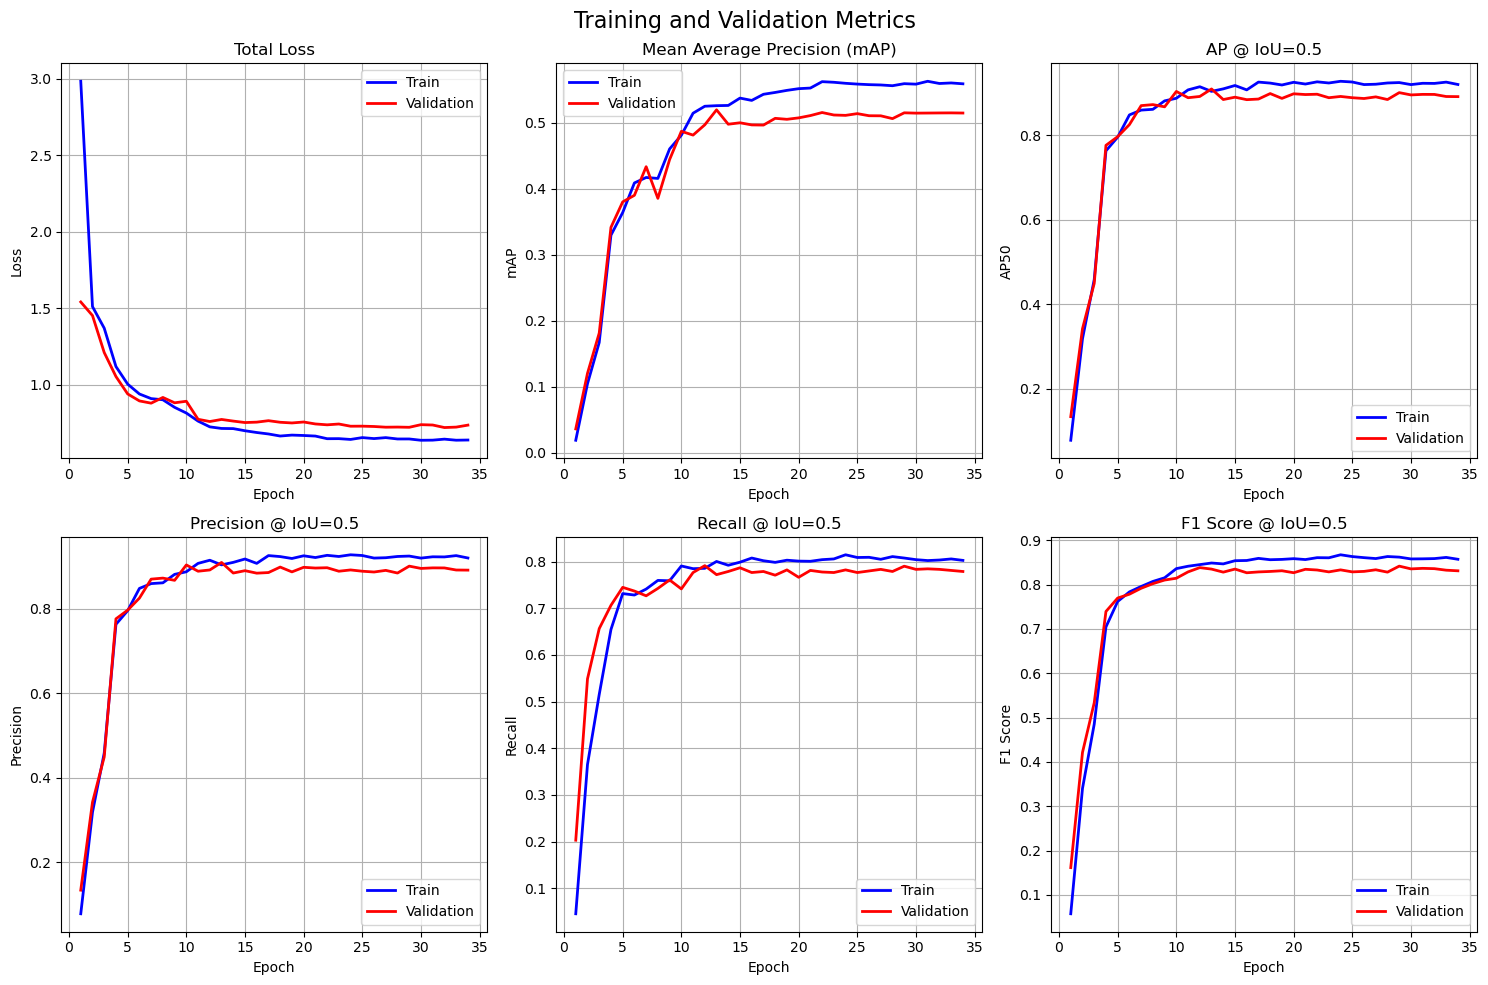

Training summary saved to: outputs/training_summary.json
✅ Training completed successfully!
   Best mAP: 0.5199
   Best epoch: 13

Step 6: Final Model Evaluation

MODEL EVALUATION

Evaluating at confidence threshold: 0.3


Eval @0.3: 100%|█████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.41s/it]


Results @ confidence 0.3:
  mAP: 0.5047
  AP50: 0.8778
  AP75: 0.5479
  Precision@0.5: 0.8778
  Recall@0.5: 0.7902
  F1@0.5: 0.8317
  Avg Inference Time: 116.80 ms
  FPS: 8.56

Evaluating at confidence threshold: 0.5


Eval @0.5: 100%|█████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.65s/it]


Results @ confidence 0.5:
  mAP: 0.5150
  AP50: 0.8911
  AP75: 0.5616
  Precision@0.5: 0.8911
  Recall@0.5: 0.7789
  F1@0.5: 0.8312
  Avg Inference Time: 116.99 ms
  FPS: 8.55

Evaluating at confidence threshold: 0.7


Eval @0.7: 100%|█████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  6.00s/it]


Results @ confidence 0.7:
  mAP: 0.5317
  AP50: 0.9133
  AP75: 0.5840
  Precision@0.5: 0.9133
  Recall@0.5: 0.7642
  F1@0.5: 0.8321
  Avg Inference Time: 116.61 ms
  FPS: 8.58

Evaluation results saved to: outputs/evaluation_results.json
✅ Evaluation completed successfully!

🏆 FINAL RESULTS (Best at conf_0.7):
   mAP: 0.5317
   AP50: 0.9133
   Precision@0.5: 0.9133
   Recall@0.5: 0.7642
   F1@0.5: 0.8321
   Inference Time: 116.61 ms
   FPS: 8.58

Step 7: Generating Final Report
📋 Final report saved to: outputs/final_report.txt

🎉 TRAINING PIPELINE COMPLETED SUCCESSFULLY!


In [9]:
# Complete training execution script
def main():
    """Execute the complete training pipeline"""
    print("🚀 STARTING COMPLETE TRAINING PIPELINE")
    print("=" * 70)
    
    # Step 1: Model instantiation and analysis (from previous chunks)
    print("Step 1: Model Instantiation and Analysis")
    model = instantiate_and_analyze_model()
    inference_time = test_model_forward_pass(model)
    
    # Step 2: Create data loaders
    print("\nStep 2: Creating Data Loaders")
    train_loader, val_loader, train_size, val_size = create_dataloaders(
        data_dir=CONFIG['data_dir'],
        batch_size=CONFIG['batch_size'],
        num_workers=CONFIG['num_workers']
    )
    
    print(f"✅ Data loaded successfully!")
    print(f"   Training samples: {train_size}")
    print(f"   Validation samples: {val_size}")
    print(f"   Training batches: {len(train_loader)}")
    print(f"   Validation batches: {len(val_loader)}")
    
    # Step 3: Sample data verification
    print("\nStep 3: Verifying Data Loading")
    try:
        sample_images, sample_targets = next(iter(train_loader))
        print(f"✅ Sample batch loaded successfully!")
        print(f"   Batch size: {len(sample_images)}")
        print(f"   Image shapes: {[img.shape for img in sample_images[:2]]}")  # Show first 2
        print(f"   Target keys: {list(sample_targets[0].keys())}")
        print(f"   Number of boxes per image: {[len(t['boxes']) for t in sample_targets]}")
    except Exception as e:
        print(f"❌ Data loading failed: {str(e)}")
        return None
    
    # Step 4: Test model with real data
    print("\nStep 4: Testing Model with Real Data")
    try:
        model.eval()
        with torch.no_grad():
            test_images = [img.to(device) for img in sample_images[:2]]  # Test with 2 images
            test_outputs = model(test_images)
            
        print(f"✅ Model forward pass with real data successful!")
        print(f"   Number of detections: {[len(out['boxes']) for out in test_outputs]}")
        if len(test_outputs[0]['scores']) > 0:
            print(f"   Score ranges: {[(out['scores'].min().item(), out['scores'].max().item()) for out in test_outputs if len(out['scores']) > 0]}")
        model.train()
    except Exception as e:
        print(f"❌ Model test failed: {str(e)}")
        return None
    
    # Step 5: Start training
    print("\nStep 5: Starting Training")
    try:
        trained_model, logger, best_map, best_epoch = train_model()
        print(f"✅ Training completed successfully!")
        print(f"   Best mAP: {best_map:.4f}")
        print(f"   Best epoch: {best_epoch}")
        
    except Exception as e:
        print(f"❌ Training failed: {str(e)}")
        return None
    
    # Step 6: Final evaluation
    print("\nStep 6: Final Model Evaluation")
    try:
        evaluation_results = evaluate_model(trained_model, val_loader)
        print(f"✅ Evaluation completed successfully!")
        
        # Print best results
        best_conf = max(evaluation_results.keys(), 
                       key=lambda x: evaluation_results[x]['mAP'])
        best_results = evaluation_results[best_conf]
        
        print(f"\n🏆 FINAL RESULTS (Best at {best_conf}):")
        print(f"   mAP: {best_results['mAP']:.4f}")
        print(f"   AP50: {best_results['AP50']:.4f}")
        print(f"   Precision@0.5: {best_results['precision@0.5']:.4f}")
        print(f"   Recall@0.5: {best_results['recall@0.5']:.4f}")
        print(f"   F1@0.5: {best_results['f1@0.5']:.4f}")
        print(f"   Inference Time: {best_results['avg_inference_time']*1000:.2f} ms")
        print(f"   FPS: {best_results['fps']:.2f}")
        
    except Exception as e:
        print(f"❌ Evaluation failed: {str(e)}")
        
    # Step 7: Generate final report
    print("\nStep 7: Generating Final Report")
    generate_final_report(logger, CONFIG)
    
    print("\n🎉 TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 70)
    
    return trained_model, logger

def generate_final_report(logger, config):
    """Generate a comprehensive final report"""
    report_path = os.path.join(config['save_dir'], 'final_report.txt')
    
    # Get metrics dataframe
    df = pd.DataFrame(logger.metrics_history)
    
    with open(report_path, 'w') as f:
        f.write("ENHANCED FASTER R-CNN BINARY BUG DETECTION - TRAINING REPORT\n")
        f.write("=" * 65 + "\n\n")
        
        # Model Configuration
        f.write("MODEL CONFIGURATION:\n")
        f.write("-" * 20 + "\n")
        f.write(f"Model: Enhanced Faster R-CNN with ResNet50-FPN backbone\n")
        f.write(f"Custom Modules: PyramidPooling + CBAM Attention\n")
        f.write(f"Classes: {config['num_classes']} (Background + Bug)\n")
        f.write(f"Backbone Freeze Ratio: {config['freeze_ratio']*100:.0f}%\n")
        f.write(f"Batch Size: {config['batch_size']}\n")
        f.write(f"Learning Rate: {config['learning_rate']}\n")
        f.write(f"Total Epochs: {config['num_epochs']}\n\n")
        
        # Training Results
        if len(df) > 0:
            train_df = df[df['phase'] == 'train']
            val_df = df[df['phase'] == 'val']
            
            f.write("TRAINING RESULTS:\n")
            f.write("-" * 17 + "\n")
            
            if len(train_df) > 0:
                final_train = train_df.iloc[-1]
                f.write(f"Final Training Metrics:\n")
                f.write(f"  Loss: {final_train['total_loss']:.4f}\n")
                f.write(f"  mAP: {final_train['mAP']:.4f}\n")
                f.write(f"  AP50: {final_train['AP50']:.4f}\n")
                f.write(f"  Precision@0.5: {final_train['precision@0.5']:.4f}\n")
                f.write(f"  Recall@0.5: {final_train['recall@0.5']:.4f}\n")
                f.write(f"  F1@0.5: {final_train['f1@0.5']:.4f}\n\n")
            
            if len(val_df) > 0:
                best_val_idx = val_df['mAP'].idxmax()
                best_val = val_df.loc[best_val_idx]
                final_val = val_df.iloc[-1]
                
                f.write(f"Best Validation Metrics (Epoch {best_val['epoch']}):\n")
                f.write(f"  Loss: {best_val['total_loss']:.4f}\n")
                f.write(f"  mAP: {best_val['mAP']:.4f}\n")
                f.write(f"  AP50: {best_val['AP50']:.4f}\n")
                f.write(f"  Precision@0.5: {best_val['precision@0.5']:.4f}\n")
                f.write(f"  Recall@0.5: {best_val['recall@0.5']:.4f}\n")
                f.write(f"  F1@0.5: {best_val['f1@0.5']:.4f}\n\n")
                
                f.write(f"Final Validation Metrics (Epoch {final_val['epoch']}):\n")
                f.write(f"  Loss: {final_val['total_loss']:.4f}\n")
                f.write(f"  mAP: {final_val['mAP']:.4f}\n")
                f.write(f"  AP50: {final_val['AP50']:.4f}\n")
                f.write(f"  Precision@0.5: {final_val['precision@0.5']:.4f}\n")
                f.write(f"  Recall@0.5: {final_val['recall@0.5']:.4f}\n")
                f.write(f"  F1@0.5: {final_val['f1@0.5']:.4f}\n\n")
        
        # File locations
        f.write("OUTPUT FILES:\n")
        f.write("-" * 13 + "\n")
        f.write(f"Model checkpoints: {config['save_dir']}/\n")
        f.write(f"Training metrics: {config['save_dir']}/training_metrics.csv\n")
        f.write(f"Training plots: {config['save_dir']}/training_metrics.png\n")
        f.write(f"Model analysis: {config['save_dir']}/model_analysis.csv\n")
        f.write(f"Evaluation results: {config['save_dir']}/evaluation_results.json\n")
        f.write(f"This report: {report_path}\n\n")
        
        f.write("MODEL READY FOR RASPBERRY PI DEPLOYMENT AFTER QUANTIZATION\n")
        f.write("Recommended: Use PyTorch Mobile or TensorRT for optimization\n")
    
    print(f"📋 Final report saved to: {report_path}")

# Execute the complete pipeline
if __name__ == "__main__":
    # Make sure CONFIG is updated with your actual data path
    CONFIG['data_dir'] = '/home/anuragaryal/coco/data'  # Update this to your actual path
    
    # Run the complete pipeline
    model, logger = main()

🔍 CPU-Only Inference Performance Analysis
Model: /home/anuragaryal/outputs/enhanced_faster_rcnn_bug_detection_best.pth
Images: /home/anuragaryal/test_img
Output: inference_results
Device: cpu
Loading model from: /home/anuragaryal/outputs/enhanced_faster_rcnn_bug_detection_best.pth
Loaded checkpoint from epoch: 13
Config found in checkpoint: {'data_dir': '/home/anuragaryal/coco/data', 'batch_size': 4, 'num_workers': 0, 'num_classes': 2, 'learning_rate': 0.001, 'num_epochs': 50, 'freeze_ratio': 0.75, 'save_dir': 'outputs', 'model_name': 'enhanced_faster_rcnn_bug_detection'}
Found 339 parameters in state dict
Sample keys: ['model.backbone.body.conv1.weight', 'model.backbone.body.bn1.weight', 'model.backbone.body.bn1.bias', 'model.backbone.body.bn1.running_mean', 'model.backbone.body.bn1.running_var']
Model analysis:
  - Has pyramid pooling: True
  - Has CBAM attention: True
  - Has backbone.body: True
  - Has model prefix: True
Cleaned state dict, new sample keys: ['backbone.body.conv1.we

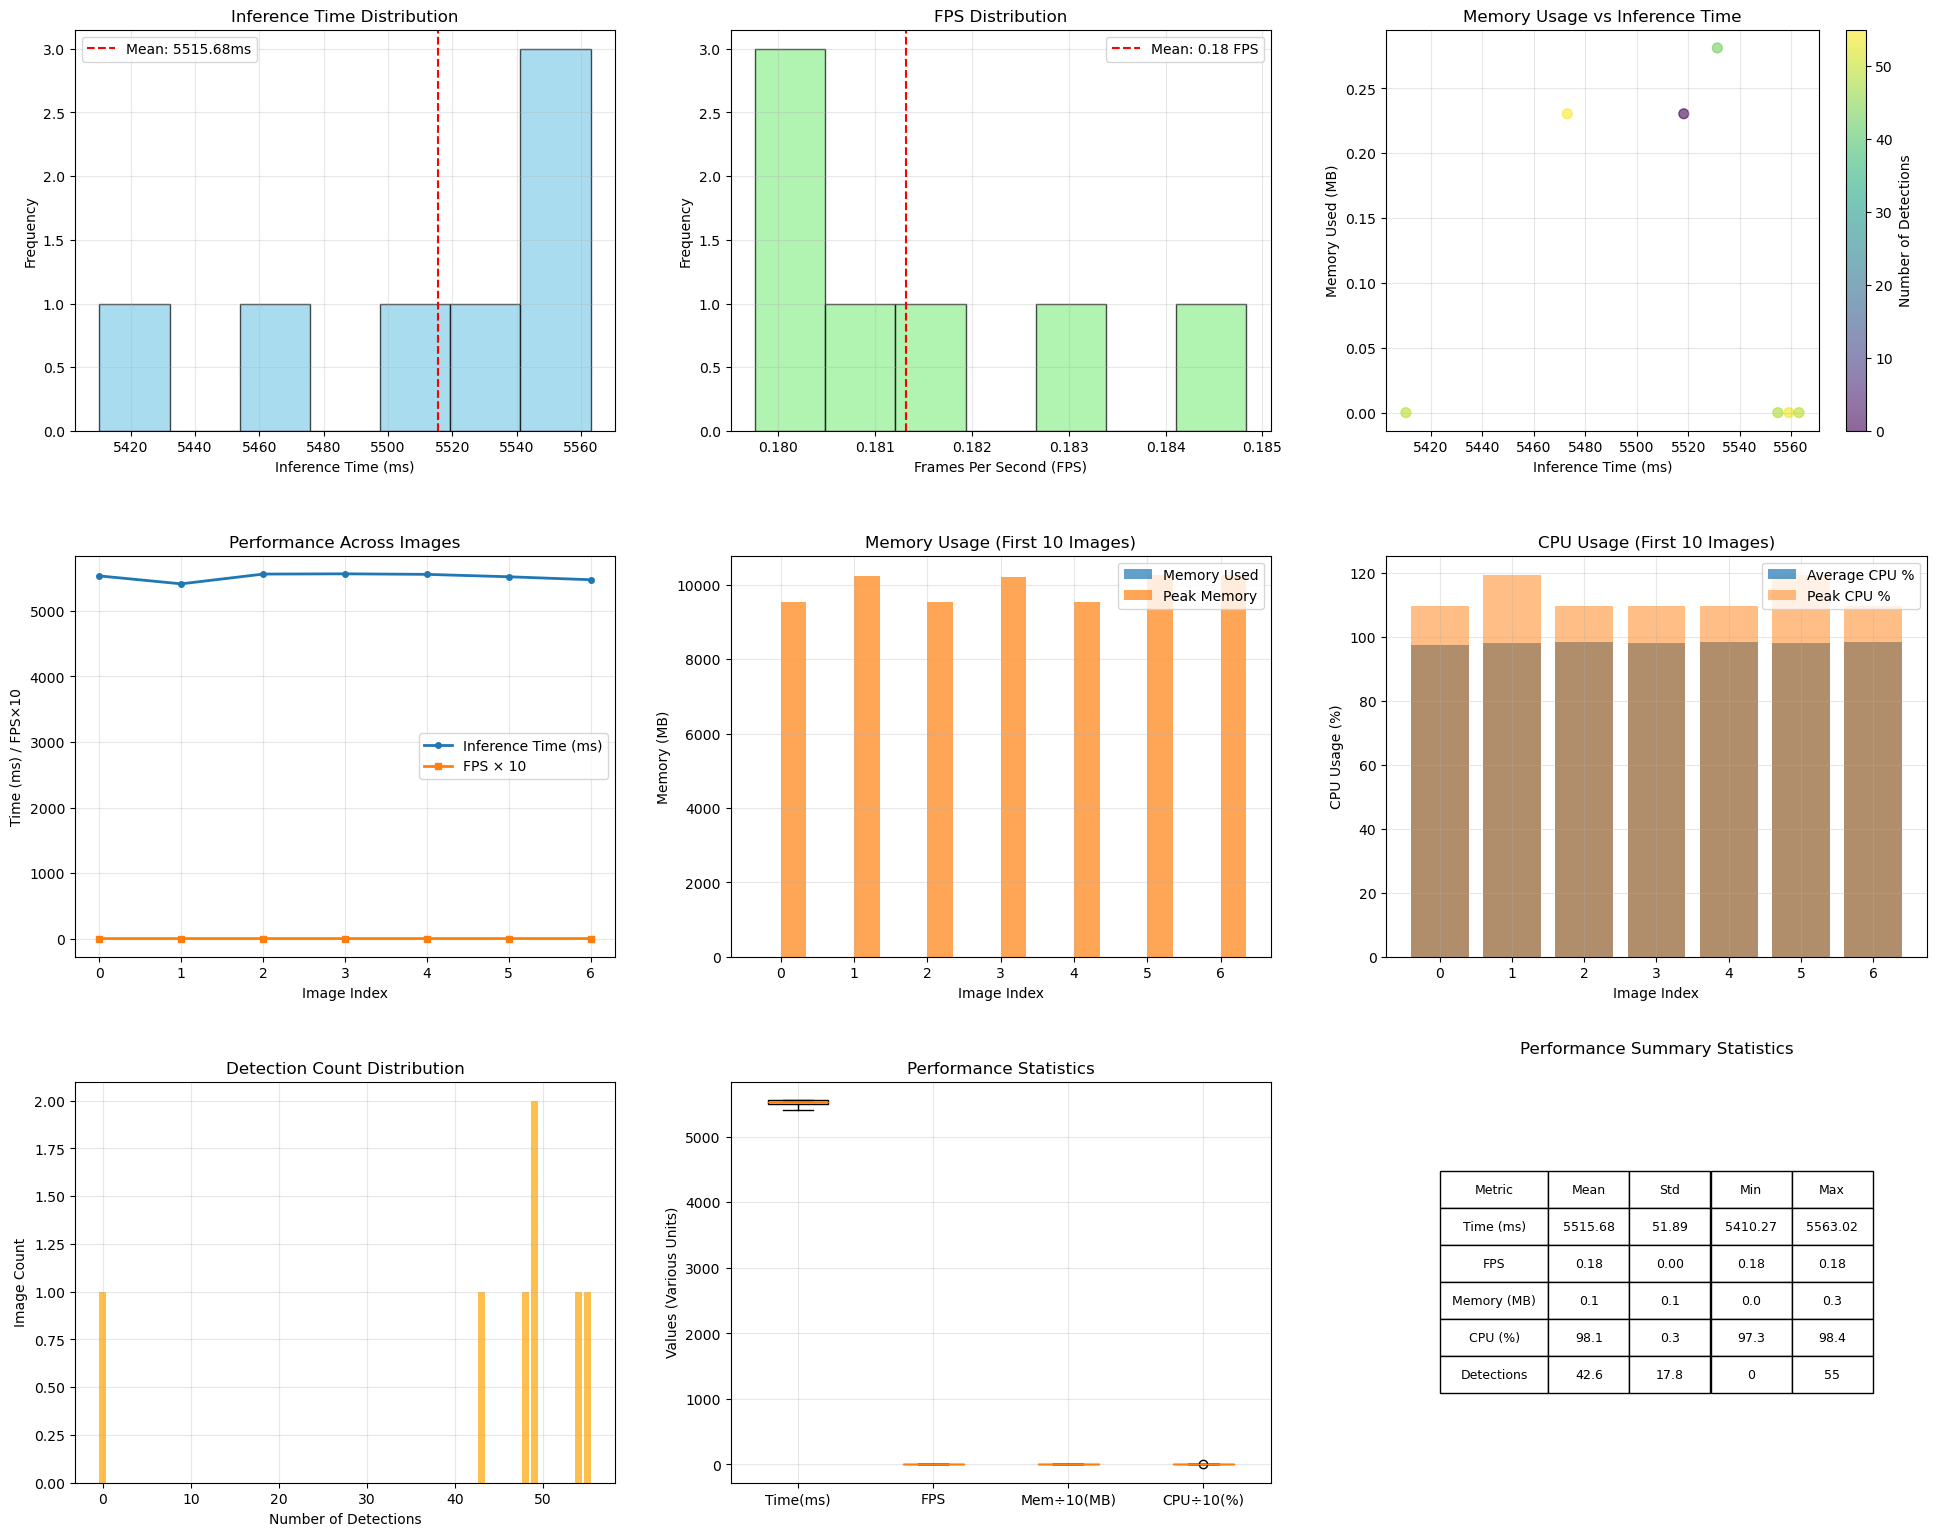

📊 Performance visualizations saved to: inference_results/performance_analysis.png
📈 Detailed monitoring plots saved for 5 images

✅ Batch inference completed!
📁 Results saved to: inference_results

🏆 REAL IMAGE INFERENCE SUMMARY
Images processed: 7
Average inference time: 5515.68 ± 51.89 ms
Average FPS: 0.18 ± 0.00
Average memory used: 0.1 ± 0.1 MB
Total detections: 298
Average detections per image: 42.6
Performance rating: 🐌 Slow (5515.68 ms avg)

📊 COMPARISON WITH SYNTHETIC BENCHMARK:
Synthetic avg: 5220.53 ms
Real images avg: 5515.68 ms
I/O + Processing overhead: 295.15 ms (5.4%)


In [10]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import time
import psutil
import threading
import json
from pathlib import Path
import cv2
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set CPU-only inference
torch.set_num_threads(1)  # Single thread for consistent measurements
device = torch.device('cpu')

class PerformanceMonitor:
    """Monitor system performance during inference"""
    
    def __init__(self):
        self.cpu_usage = []
        self.memory_usage = []
        self.timestamps = []
        self.monitoring = False
        self.monitor_thread = None
        self.process = psutil.Process()
        
    def start_monitoring(self):
        """Start performance monitoring in background thread"""
        self.monitoring = True
        self.cpu_usage = []
        self.memory_usage = []
        self.timestamps = []
        self.monitor_thread = threading.Thread(target=self._monitor_loop)
        self.monitor_thread.start()
        
    def stop_monitoring(self):
        """Stop performance monitoring"""
        self.monitoring = False
        if self.monitor_thread:
            self.monitor_thread.join()
            
    def _monitor_loop(self):
        """Background monitoring loop"""
        start_time = time.time()
        while self.monitoring:
            try:
                # CPU usage for this process
                cpu_percent = self.process.cpu_percent()
                
                # Memory usage in MB
                memory_info = self.process.memory_info()
                memory_mb = memory_info.rss / 1024 / 1024
                
                # Timestamp relative to start
                timestamp = time.time() - start_time
                
                self.cpu_usage.append(cpu_percent)
                self.memory_usage.append(memory_mb)
                self.timestamps.append(timestamp)
                
                time.sleep(0.1)  # Sample every 100ms
            except:
                break

class InferenceAnalyzer:
    """Comprehensive inference analysis for trained model"""
    
    def __init__(self, model_path, config_path=None):
        self.model_path = model_path
        self.device = device
        self.model = None
        self.transform = None
        self.results = []
        self.performance_monitor = PerformanceMonitor()
        
        # Load configuration if provided
        self.config = self._load_config(config_path) if config_path else {}
        
        # Setup
        self._load_model()
        self._setup_transform()
        
    def _load_config(self, config_path):
        """Load configuration from JSON file"""
        try:
            with open(config_path, 'r') as f:
                return json.load(f)
        except:
            return {}
    
    def _load_model(self):
        """Load the trained model with proper architecture recreation"""
        print(f"Loading model from: {self.model_path}")
        
        try:
            # Load checkpoint
            checkpoint = torch.load(self.model_path, map_location=self.device)
            
            # Extract model if it's wrapped in checkpoint
            if isinstance(checkpoint, dict):
                if 'model_state_dict' in checkpoint:
                    model_state = checkpoint['model_state_dict']
                    print(f"Loaded checkpoint from epoch: {checkpoint.get('epoch', 'Unknown')}")
                    if 'config' in checkpoint:
                        print(f"Config found in checkpoint: {checkpoint['config']}")
                elif 'model' in checkpoint:
                    model_state = checkpoint['model']
                else:
                    model_state = checkpoint
            else:
                model_state = checkpoint
            
            # If model_state has a 'model' key, extract it
            if 'model' in model_state and hasattr(model_state['model'], 'state_dict'):
                # This is a wrapped model
                self.model = model_state['model']
                self.model.to(self.device)
                self.model.eval()
                print("✅ Loaded complete model object from checkpoint")
            else:
                # Try to determine model architecture from state dict keys
                state_keys = list(model_state.keys())
                print(f"Found {len(state_keys)} parameters in state dict")
                print(f"Sample keys: {state_keys[:5]}")
                
                # Check if this is an enhanced model with custom modules
                has_pyramid_pooling = any('pyramid_pooling' in key for key in state_keys)
                has_cbam = any('cbam' in key or 'channel_attention' in key or 'spatial_attention' in key for key in state_keys)
                has_backbone_body = any('backbone.body' in key for key in state_keys)
                has_model_prefix = any(key.startswith('model.') for key in state_keys)
                
                print(f"Model analysis:")
                print(f"  - Has pyramid pooling: {has_pyramid_pooling}")
                print(f"  - Has CBAM attention: {has_cbam}")
                print(f"  - Has backbone.body: {has_backbone_body}")
                print(f"  - Has model prefix: {has_model_prefix}")
                
                # Remove 'model.' prefix if present
                if has_model_prefix:
                    clean_state = {}
                    for key, value in model_state.items():
                        if key.startswith('model.'):
                            clean_state[key[6:]] = value  # Remove 'model.' prefix
                        else:
                            clean_state[key] = value
                    model_state = clean_state
                    state_keys = list(model_state.keys())
                    print(f"Cleaned state dict, new sample keys: {state_keys[:5]}")
                
                # Determine number of classes from classifier
                num_classes = 2  # default
                for key in state_keys:
                    if 'roi_heads.box_predictor.cls_score.weight' in key:
                        num_classes = model_state[key].shape[0]
                        break
                
                print(f"Detected num_classes: {num_classes}")
                
                # Try different model creation strategies
                model_created = False
                
                # Strategy 1: Try to recreate enhanced model
                if has_pyramid_pooling or has_cbam:
                    try:
                        self.model = self._create_enhanced_model(num_classes, has_pyramid_pooling, has_cbam)
                        model_created = True
                        print("✅ Created enhanced model architecture")
                    except Exception as e:
                        print(f"Failed to create enhanced model: {e}")
                
                # Strategy 2: Try standard Faster R-CNN
                if not model_created:
                    try:
                        from torchvision.models.detection import fasterrcnn_resnet50_fpn
                        self.model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)
                        model_created = True
                        print("✅ Created standard Faster R-CNN model")
                    except Exception as e:
                        print(f"Failed to create standard model: {e}")
                
                # Strategy 3: Try loading with strict=False
                if not model_created:
                    from torchvision.models.detection import fasterrcnn_resnet50_fpn
                    self.model = fasterrcnn_resnet50_fpn(pretrained=True, num_classes=num_classes)
                    print("⚠️  Using pretrained model as fallback")
                    model_created = True
                
                if not model_created:
                    raise Exception("Could not create compatible model architecture")
                
                # Try to load state dict with different strategies
                try:
                    # Strategy 1: Exact match
                    self.model.load_state_dict(model_state, strict=True)
                    print("✅ Loaded state dict with exact match")
                except Exception as e1:
                    print(f"Exact match failed: {str(e1)[:200]}...")
                    try:
                        # Strategy 2: Partial match
                        missing_keys, unexpected_keys = self.model.load_state_dict(model_state, strict=False)
                        print(f"⚠️  Loaded state dict with partial match")
                        print(f"    Missing keys: {len(missing_keys)}")
                        print(f"    Unexpected keys: {len(unexpected_keys)}")
                        if missing_keys:
                            print(f"    Sample missing: {list(missing_keys)[:3]}")
                        if unexpected_keys:
                            print(f"    Sample unexpected: {list(unexpected_keys)[:3]}")
                    except Exception as e2:
                        print(f"Partial match failed: {str(e2)[:200]}...")
                        print("⚠️  Using randomly initialized model - predictions may be poor")
                
                self.model.to(self.device)
                self.model.eval()
            
            # Test forward pass with correct input format
            test_input = torch.randn(3, 224, 224).to(self.device)  # Single image tensor
            with torch.no_grad():
                test_output = self.model([test_input])  # Pass as list
            print("✅ Model forward pass test successful!")
            
        except Exception as e:
            print(f"❌ Error loading model: {str(e)}")
            raise
    
    def _create_enhanced_model(self, num_classes, has_pyramid_pooling=False, has_cbam=False):
        """Recreate enhanced model architecture"""
        import torch.nn as nn
        from torchvision.models.detection import fasterrcnn_resnet50_fpn
        from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
        
        # Create base model
        model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)
        
        # Add custom modules if detected
        if has_pyramid_pooling:
            # Add pyramid pooling module
            class PyramidPoolingModule(nn.Module):
                def __init__(self, in_channels, out_channels=256):
                    super().__init__()
                    self.pools = nn.ModuleList([
                        nn.AdaptiveAvgPool2d((1, 1)),
                        nn.AdaptiveAvgPool2d((2, 2)),
                        nn.AdaptiveAvgPool2d((3, 3)),
                        nn.AdaptiveAvgPool2d((6, 6))
                    ])
                    self.convs = nn.ModuleList([
                        nn.Conv2d(in_channels, out_channels//4, 1, bias=False)
                        for _ in range(4)
                    ])
                    self.bn = nn.BatchNorm2d(out_channels)
                    self.relu = nn.ReLU(inplace=True)
                    self.final_conv = nn.Conv2d(in_channels + out_channels, out_channels, 3, padding=1, bias=False)
                    
                def forward(self, x):
                    h, w = x.size(2), x.size(3)
                    pyramid_features = []
                    
                    for pool, conv in zip(self.pools, self.convs):
                        pooled = pool(x)
                        conv_out = conv(pooled)
                        upsampled = F.interpolate(conv_out, size=(h, w), mode='bilinear', align_corners=False)
                        pyramid_features.append(upsampled)
                    
                    pyramid_out = torch.cat(pyramid_features, dim=1)
                    pyramid_out = self.bn(pyramid_out)
                    pyramid_out = self.relu(pyramid_out)
                    
                    combined = torch.cat([x, pyramid_out], dim=1)
                    out = self.final_conv(combined)
                    return out
            
            # Add to backbone
            model.backbone.pyramid_pooling = PyramidPoolingModule(256, 256)
        
        if has_cbam:
            # Add CBAM attention module
            class ChannelAttention(nn.Module):
                def __init__(self, in_channels, reduction=16):
                    super().__init__()
                    self.avg_pool = nn.AdaptiveAvgPool2d(1)
                    self.max_pool = nn.AdaptiveMaxPool2d(1)
                    self.fc = nn.Sequential(
                        nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
                        nn.ReLU(),
                        nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
                    )
                    self.sigmoid = nn.Sigmoid()
                    
                def forward(self, x):
                    avg_out = self.fc(self.avg_pool(x))
                    max_out = self.fc(self.max_pool(x))
                    out = avg_out + max_out
                    return self.sigmoid(out)
            
            class SpatialAttention(nn.Module):
                def __init__(self, kernel_size=7):
                    super().__init__()
                    self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
                    self.sigmoid = nn.Sigmoid()
                    
                def forward(self, x):
                    avg_out = torch.mean(x, dim=1, keepdim=True)
                    max_out, _ = torch.max(x, dim=1, keepdim=True)
                    x_cat = torch.cat([avg_out, max_out], dim=1)
                    out = self.conv(x_cat)
                    return self.sigmoid(out)
            
            class CBAM(nn.Module):
                def __init__(self, in_channels, reduction=16, kernel_size=7):
                    super().__init__()
                    self.channel_attention = ChannelAttention(in_channels, reduction)
                    self.spatial_attention = SpatialAttention(kernel_size)
                    
                def forward(self, x):
                    x = x * self.channel_attention(x)
                    x = x * self.spatial_attention(x)
                    return x
            
            # Add CBAM to backbone
            model.backbone.cbam = CBAM(256)
        
        return model
    
    def _setup_transform(self):
        """Setup image preprocessing transforms"""
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    
    def preprocess_image(self, image_path):
        """Preprocess image for inference"""
        try:
            # Load image
            image = Image.open(image_path).convert('RGB')
            original_size = image.size
            
            # Transform
            tensor_image = self.transform(image)
            
            return tensor_image, image, original_size
            
        except Exception as e:
            print(f"Error preprocessing {image_path}: {str(e)}")
            return None, None, None
    
    def run_single_inference(self, image_path, conf_threshold=0.5):
        """Run inference on single image with detailed performance tracking"""
        
        # Preprocess
        tensor_image, pil_image, original_size = self.preprocess_image(image_path)
        if tensor_image is None:
            return None, None
        
        # Start monitoring
        self.performance_monitor.start_monitoring()
        
        # Memory before inference
        memory_before = psutil.Process().memory_info().rss / 1024 / 1024
        
        # Warm up (not counted) - FIXED: Pass tensor as list element
        with torch.no_grad():
            _ = self.model([tensor_image.to(self.device)])
        
        # Clear cache and small delay
        time.sleep(0.1)
        
        # Actual inference timing - FIXED: Pass tensor as list element
        start_time = time.time()
        
        with torch.no_grad():
            predictions = self.model([tensor_image.to(self.device)])
        
        end_time = time.time()
        inference_time = end_time - start_time
        
        # Memory after inference
        memory_after = psutil.Process().memory_info().rss / 1024 / 1024
        memory_used = memory_after - memory_before
        
        # Stop monitoring
        time.sleep(0.2)  # Allow a bit more monitoring data
        self.performance_monitor.stop_monitoring()
        
        # Process predictions
        pred = predictions[0]
        boxes = pred['boxes'].cpu().numpy()
        scores = pred['scores'].cpu().numpy()
        labels = pred['labels'].cpu().numpy()
        
        # Filter by confidence
        keep_idx = scores >= conf_threshold
        filtered_boxes = boxes[keep_idx]
        filtered_scores = scores[keep_idx]
        filtered_labels = labels[keep_idx]
        
        # Calculate FPS
        fps = 1.0 / inference_time if inference_time > 0 else 0
        
        # Store results
        result = {
            'image_path': image_path,
            'image_name': os.path.basename(image_path),
            'inference_time_ms': inference_time * 1000,
            'fps': fps,
            'memory_used_mb': memory_used,
            'total_memory_mb': memory_after,
            'num_detections': len(filtered_boxes),
            'boxes': filtered_boxes.tolist(),
            'scores': filtered_scores.tolist(),
            'labels': filtered_labels.tolist(),
            'image_size': original_size,
            'conf_threshold': conf_threshold,
            'cpu_usage_avg': np.mean(self.performance_monitor.cpu_usage) if self.performance_monitor.cpu_usage else 0,
            'cpu_usage_max': np.max(self.performance_monitor.cpu_usage) if self.performance_monitor.cpu_usage else 0,
            'memory_peak_mb': np.max(self.performance_monitor.memory_usage) if self.performance_monitor.memory_usage else memory_after,
            'monitoring_data': {
                'timestamps': self.performance_monitor.timestamps.copy(),
                'cpu_usage': self.performance_monitor.cpu_usage.copy(),
                'memory_usage': self.performance_monitor.memory_usage.copy()
            }
        }
        
        return result, pil_image
    
    def batch_inference(self, image_dir, output_dir, conf_threshold=0.5, max_images=None):
        """Run inference on batch of images"""
        
        print(f"🔍 Starting batch inference on images in: {image_dir}")
        print(f"📊 Confidence threshold: {conf_threshold}")
        print(f"💻 Device: {self.device}")
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Get image files
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
        image_files = []
        
        for ext in image_extensions:
            image_files.extend(Path(image_dir).glob(f'*{ext}'))
            image_files.extend(Path(image_dir).glob(f'*{ext.upper()}'))
        
        if max_images:
            image_files = image_files[:max_images]
        
        print(f"📁 Found {len(image_files)} images to process")
        
        if len(image_files) == 0:
            print("❌ No images found! Please check the image directory path.")
            return []
        
        # Process each image
        all_results = []
        
        for i, image_path in enumerate(image_files, 1):
            print(f"Processing {i}/{len(image_files)}: {image_path.name}")
            
            try:
                result, pil_image = self.run_single_inference(str(image_path), conf_threshold)
                
                if result and pil_image:
                    all_results.append(result)
                    
                    # Save annotated image
                    annotated_image = self.visualize_detections(pil_image.copy(), result)
                    output_path = os.path.join(output_dir, f"annotated_{image_path.name}")
                    annotated_image.save(output_path)
                    
                    print(f"  ⏱️  Inference time: {result['inference_time_ms']:.2f}ms")
                    print(f"  🎯 Detections: {result['num_detections']}")
                    print(f"  💾 Memory used: {result['memory_used_mb']:.1f}MB")
                    print(f"  📈 FPS: {result['fps']:.2f}")
                    
            except Exception as e:
                print(f"  ❌ Error: {str(e)}")
        
        # Save results
        self.results = all_results
        if all_results:
            self.save_results(output_dir)
            
            # Generate visualizations
            self.create_performance_visualizations(output_dir)
        
        print(f"\n✅ Batch inference completed!")
        print(f"📁 Results saved to: {output_dir}")
        
        return all_results
    
    def visualize_detections(self, pil_image, result):
        """Visualize detections on image"""
        draw = ImageDraw.Draw(pil_image)
        
        # Try to load a font, fallback to default if not available
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 16)
        except:
            try:
                font = ImageFont.truetype("/System/Library/Fonts/Arial.ttf", 16)
            except:
                font = ImageFont.load_default()
        
        # Colors for different classes
        colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']
        
        for i, (box, score, label) in enumerate(zip(result['boxes'], result['scores'], result['labels'])):
            x1, y1, x2, y2 = box
            color = colors[label % len(colors)]
            
            # Draw bounding box
            draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
            
            # Draw label and score
            label_text = f"Bug: {score:.2f}"
            
            # Get text size for background
            try:
                bbox = draw.textbbox((0, 0), label_text, font=font)
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]
            except:
                # Fallback for older PIL versions
                text_width, text_height = draw.textsize(label_text, font=font)
            
            # Draw background for text
            draw.rectangle([x1, y1-text_height-4, x1+text_width+8, y1], fill=color)
            
            # Draw text
            draw.text((x1+4, y1-text_height-2), label_text, fill='white', font=font)
        
        return pil_image
    
    def save_results(self, output_dir):
        """Save inference results to files"""
        
        # Save detailed results as JSON
        results_path = os.path.join(output_dir, 'inference_results.json')
        with open(results_path, 'w') as f:
            json.dump(self.results, f, indent=2, default=str)
        
        # Save summary as CSV
        summary_data = []
        for result in self.results:
            summary_data.append({
                'image_name': result['image_name'],
                'inference_time_ms': result['inference_time_ms'],
                'fps': result['fps'],
                'memory_used_mb': result['memory_used_mb'],
                'total_memory_mb': result['total_memory_mb'],
                'num_detections': result['num_detections'],
                'cpu_usage_avg': result['cpu_usage_avg'],
                'cpu_usage_max': result['cpu_usage_max'],
                'memory_peak_mb': result['memory_peak_mb']
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_path = os.path.join(output_dir, 'inference_summary.csv')
        summary_df.to_csv(summary_path, index=False)
        
        print(f"📊 Results saved to: {results_path}")
        print(f"📈 Summary saved to: {summary_path}")
    
    def create_performance_visualizations(self, output_dir):
        """Create comprehensive performance visualizations"""
        
        if not self.results:
            print("No results to visualize")
            return
        
        # Set style
        plt.style.use('default')  # More compatible style
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 16))
        
        # Extract data
        image_names = [r['image_name'] for r in self.results]
        inference_times = [r['inference_time_ms'] for r in self.results]
        fps_values = [r['fps'] for r in self.results]
        memory_used = [r['memory_used_mb'] for r in self.results]
        total_memory = [r['total_memory_mb'] for r in self.results]
        num_detections = [r['num_detections'] for r in self.results]
        cpu_usage_avg = [r['cpu_usage_avg'] for r in self.results]
        cpu_usage_max = [r['cpu_usage_max'] for r in self.results]
        memory_peaks = [r['memory_peak_mb'] for r in self.results]
        
        # 1. Inference Time Distribution
        plt.subplot(3, 3, 1)
        plt.hist(inference_times, bins=min(20, len(inference_times)), alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(np.mean(inference_times), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(inference_times):.2f}ms')
        plt.xlabel('Inference Time (ms)')
        plt.ylabel('Frequency')
        plt.title('Inference Time Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. FPS Distribution
        plt.subplot(3, 3, 2)
        plt.hist(fps_values, bins=min(20, len(fps_values)), alpha=0.7, color='lightgreen', edgecolor='black')
        plt.axvline(np.mean(fps_values), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(fps_values):.2f} FPS')
        plt.xlabel('Frames Per Second (FPS)')
        plt.ylabel('Frequency')
        plt.title('FPS Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Memory Usage vs Inference Time
        plt.subplot(3, 3, 3)
        scatter = plt.scatter(inference_times, memory_used, c=num_detections, 
                            cmap='viridis', alpha=0.6, s=50)
        plt.colorbar(scatter, label='Number of Detections')
        plt.xlabel('Inference Time (ms)')
        plt.ylabel('Memory Used (MB)')
        plt.title('Memory Usage vs Inference Time')
        plt.grid(True, alpha=0.3)
        
        # 4. Performance over Images
        plt.subplot(3, 3, 4)
        x_range = range(len(image_names))
        plt.plot(x_range, inference_times, 'o-', label='Inference Time (ms)', linewidth=2, markersize=4)
        plt.plot(x_range, [f*10 for f in fps_values], 's-', label='FPS × 10', linewidth=2, markersize=4)
        plt.xlabel('Image Index')
        plt.ylabel('Time (ms) / FPS×10')
        plt.title('Performance Across Images')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 5. Memory Usage Breakdown
        plt.subplot(3, 3, 5)
        width = 0.35
        x = np.arange(min(len(memory_used), 10))  # Show first 10 images
        
        if len(memory_used) > 0:
            plt.bar(x - width/2, memory_used[:10], width, label='Memory Used', alpha=0.7)
            plt.bar(x + width/2, memory_peaks[:10], width, label='Peak Memory', alpha=0.7)
            plt.xlabel('Image Index')
            plt.ylabel('Memory (MB)')
            plt.title('Memory Usage (First 10 Images)')
            plt.legend()
            plt.xticks(x)
        plt.grid(True, alpha=0.3)
        
        # 6. CPU Usage
        plt.subplot(3, 3, 6)
        x_cpu = range(min(len(cpu_usage_avg), 10))
        plt.bar(x_cpu, cpu_usage_avg[:10], alpha=0.7, label='Average CPU %')
        plt.bar(x_cpu, cpu_usage_max[:10], alpha=0.5, label='Peak CPU %')
        plt.xlabel('Image Index')
        plt.ylabel('CPU Usage (%)')
        plt.title('CPU Usage (First 10 Images)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 7. Detection Count Distribution
        plt.subplot(3, 3, 7)
        if num_detections:
            max_detections = max(num_detections)
            detection_counts = np.bincount(num_detections, minlength=max_detections+1)
            plt.bar(range(len(detection_counts)), detection_counts, alpha=0.7, color='orange')
            plt.xlabel('Number of Detections')
            plt.ylabel('Image Count')
            plt.title('Detection Count Distribution')
        plt.grid(True, alpha=0.3)
        
        # 8. Performance Statistics Box Plot
        plt.subplot(3, 3, 8)
        data_to_plot = [inference_times, fps_values, 
                       [m/10 for m in memory_used],  # Scale memory for visibility
                       [c/10 for c in cpu_usage_avg]]  # Scale CPU for visibility
        labels = ['Time(ms)', 'FPS', 'Mem÷10(MB)', 'CPU÷10(%)']
        
        box_plot = plt.boxplot(data_to_plot, labels=labels, patch_artist=True)
        colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)
        plt.title('Performance Statistics')
        plt.ylabel('Values (Various Units)')
        plt.grid(True, alpha=0.3)
        
        # 9. Summary Statistics Table
        plt.subplot(3, 3, 9)
        plt.axis('off')
        
        stats_data = [
            ['Metric', 'Mean', 'Std', 'Min', 'Max'],
            ['Time (ms)', f'{np.mean(inference_times):.2f}', f'{np.std(inference_times):.2f}', 
             f'{np.min(inference_times):.2f}', f'{np.max(inference_times):.2f}'],
            ['FPS', f'{np.mean(fps_values):.2f}', f'{np.std(fps_values):.2f}', 
             f'{np.min(fps_values):.2f}', f'{np.max(fps_values):.2f}'],
            ['Memory (MB)', f'{np.mean(memory_used):.1f}', f'{np.std(memory_used):.1f}', 
             f'{np.min(memory_used):.1f}', f'{np.max(memory_used):.1f}'],
            ['CPU (%)', f'{np.mean(cpu_usage_avg):.1f}', f'{np.std(cpu_usage_avg):.1f}', 
             f'{np.min(cpu_usage_avg):.1f}', f'{np.max(cpu_usage_avg):.1f}'],
            ['Detections', f'{np.mean(num_detections):.1f}', f'{np.std(num_detections):.1f}', 
             f'{np.min(num_detections)}', f'{np.max(num_detections)}']
        ]
        
        table = plt.table(cellText=stats_data, cellLoc='center', loc='center',
                         colWidths=[0.2, 0.15, 0.15, 0.15, 0.15])
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)
        plt.title('Performance Summary Statistics', pad=20)
        
        plt.tight_layout(pad=3.0)
        
        # Save plots
        plots_path = os.path.join(output_dir, 'performance_analysis.png')
        plt.savefig(plots_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"📊 Performance visualizations saved to: {plots_path}")
        
        # Create individual monitoring plots for first few images
        self.create_detailed_monitoring_plots(output_dir)
    
    def create_detailed_monitoring_plots(self, output_dir, max_plots=5):
        """Create detailed monitoring plots for individual images"""
        
        num_plots = min(len(self.results), max_plots)
        
        for i in range(num_plots):
            result = self.results[i]
            monitoring_data = result.get('monitoring_data', {})
            
            if not monitoring_data.get('timestamps'):
                continue
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
            
            timestamps = monitoring_data['timestamps']
            cpu_usage = monitoring_data['cpu_usage']
            memory_usage = monitoring_data['memory_usage']
            
            # CPU Usage over time
            ax1.plot(timestamps, cpu_usage, 'b-', linewidth=2, label='CPU Usage (%)')
            ax1.fill_between(timestamps, cpu_usage, alpha=0.3)
            ax1.set_ylabel('CPU Usage (%)')
            ax1.set_title(f'System Monitoring: {result["image_name"]}')
            ax1.grid(True, alpha=0.3)
            ax1.legend()
            
            # Memory Usage over time
            ax2.plot(timestamps, memory_usage, 'r-', linewidth=2, label='Memory Usage (MB)')
            ax2.fill_between(timestamps, memory_usage, alpha=0.3, color='red')
            ax2.set_xlabel('Time (seconds)')
            ax2.set_ylabel('Memory Usage (MB)')
            ax2.grid(True, alpha=0.3)
            ax2.legend()
            
            # Add inference metrics as text
            metrics_text = f"""
Inference Time: {result['inference_time_ms']:.2f} ms
FPS: {result['fps']:.2f}
Detections: {result['num_detections']}
Memory Used: {result['memory_used_mb']:.1f} MB
            """.strip()
            
            ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            plt.tight_layout()
            
            # Save individual monitoring plot
            plot_path = os.path.join(output_dir, f'monitoring_{i+1}_{result["image_name"].split(".")[0]}.png')
            plt.savefig(plot_path, dpi=200, bbox_inches='tight')
            plt.close()
        
        print(f"📈 Detailed monitoring plots saved for {num_plots} images")

    def benchmark_model(self, num_iterations=100):
        """Run benchmark with synthetic data to test pure model performance"""
        print(f"🔥 Running model benchmark with {num_iterations} iterations...")
        
        # Create synthetic input
        synthetic_image = torch.randn(3, 640, 480).to(self.device)
        
        # Warm up
        with torch.no_grad():
            for _ in range(10):
                _ = self.model([synthetic_image])
        
        # Benchmark
        times = []
        start_mem = psutil.Process().memory_info().rss / 1024 / 1024
        
        for i in range(num_iterations):
            start_time = time.time()
            with torch.no_grad():
                _ = self.model([synthetic_image])
            end_time = time.time()
            times.append((end_time - start_time) * 1000)  # Convert to ms
            
            if (i + 1) % 20 == 0:
                print(f"  Completed {i + 1}/{num_iterations} iterations...")
        
        end_mem = psutil.Process().memory_info().rss / 1024 / 1024
        
        # Results
        mean_time = np.mean(times)
        std_time = np.std(times)
        min_time = np.min(times)
        max_time = np.max(times)
        memory_delta = end_mem - start_mem
        
        print(f"\n🏆 BENCHMARK RESULTS:")
        print(f"Mean inference time: {mean_time:.2f} ± {std_time:.2f} ms")
        print(f"Min/Max time: {min_time:.2f} / {max_time:.2f} ms")
        print(f"Average FPS: {1000/mean_time:.2f}")
        print(f"Memory delta: {memory_delta:.2f} MB")
        
        return {
            'mean_time_ms': mean_time,
            'std_time_ms': std_time,
            'min_time_ms': min_time,
            'max_time_ms': max_time,
            'avg_fps': 1000/mean_time,
            'memory_delta_mb': memory_delta,
            'iterations': num_iterations
        }

def main():
    """Main function to run inference analysis"""
    
    # Configuration
    model_path = '/home/anuragaryal/outputs/enhanced_faster_rcnn_bug_detection_best.pth'  # Update this path     
    images_dir = '/home/anuragaryal/test_img'
    output_dir = 'inference_results'
    conf_threshold = 0.5
    max_images = 50  # Limit for testing, set to None for all images
    
    print("🔍 CPU-Only Inference Performance Analysis")
    print("=" * 50)
    print(f"Model: {model_path}")
    print(f"Images: {images_dir}")
    print(f"Output: {output_dir}")
    print(f"Device: {device}")
    print("=" * 50)
    
    try:
        # Initialize analyzer
        analyzer = InferenceAnalyzer(model_path)
        
        # Run synthetic benchmark first
        benchmark_results = analyzer.benchmark_model(num_iterations=50)
        
        # Run batch inference on real images
        results = analyzer.batch_inference(
            image_dir=images_dir,
            output_dir=output_dir,
            conf_threshold=conf_threshold,
            max_images=max_images
        )
        
        # Print summary
        if results:
            inference_times = [r['inference_time_ms'] for r in results]
            fps_values = [r['fps'] for r in results]
            memory_used = [r['memory_used_mb'] for r in results]
            detections = [r['num_detections'] for r in results]
            
            print(f"\n🏆 REAL IMAGE INFERENCE SUMMARY")
            print(f"Images processed: {len(results)}")
            print(f"Average inference time: {np.mean(inference_times):.2f} ± {np.std(inference_times):.2f} ms")
            print(f"Average FPS: {np.mean(fps_values):.2f} ± {np.std(fps_values):.2f}")
            print(f"Average memory used: {np.mean(memory_used):.1f} ± {np.std(memory_used):.1f} MB")
            print(f"Total detections: {sum(detections)}")
            print(f"Average detections per image: {np.mean(detections):.1f}")
            
            # Performance classification
            avg_time = np.mean(inference_times)
            if avg_time < 100:
                performance = "🚀 Excellent"
            elif avg_time < 250:
                performance = "⚡ Good"
            elif avg_time < 500:
                performance = "🔋 Moderate"
            else:
                performance = "🐌 Slow"
            
            print(f"Performance rating: {performance} ({avg_time:.2f} ms avg)")
            
            # Compare with synthetic benchmark
            print(f"\n📊 COMPARISON WITH SYNTHETIC BENCHMARK:")
            print(f"Synthetic avg: {benchmark_results['mean_time_ms']:.2f} ms")
            print(f"Real images avg: {avg_time:.2f} ms")
            overhead = avg_time - benchmark_results['mean_time_ms']
            print(f"I/O + Processing overhead: {overhead:.2f} ms ({overhead/avg_time*100:.1f}%)")
        
    except Exception as e:
        print(f"❌ Error during analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    main()

In [11]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cpu')

class BugDetectionEvaluator:
    """Evaluate bug detection model on real test images"""
    
    def __init__(self, model_path):
        self.model_path = model_path
        self.device = device
        self.model = None
        self.transform = None
        self.class_names = {0: 'background', 1: 'bug'}  # Adjust based on your classes
        
        self._load_model()
        self._setup_transform()
        
    def _load_model(self):
        """Load the trained model"""
        print(f"🔄 Loading model from: {self.model_path}")
        
        try:
            # Load checkpoint
            checkpoint = torch.load(self.model_path, map_location=self.device)
            print(f"✅ Checkpoint loaded successfully")
            
            # Handle different checkpoint formats
            if isinstance(checkpoint, dict):
                if 'model' in checkpoint and hasattr(checkpoint['model'], 'eval'):
                    # Complete model object
                    self.model = checkpoint['model']
                    print("✅ Loaded complete model object")
                else:
                    # State dict - try to create compatible model
                    if 'model_state_dict' in checkpoint:
                        model_state = checkpoint['model_state_dict']
                        print(f"📊 Epoch: {checkpoint.get('epoch', 'Unknown')}")
                        if 'config' in checkpoint:
                            print(f"📋 Config: {checkpoint['config']}")
                    else:
                        model_state = checkpoint
                    
                    # Create model architecture
                    from torchvision.models.detection import fasterrcnn_resnet50_fpn
                    
                    # Remove 'model.' prefix if present
                    clean_state = {}
                    for key, value in model_state.items():
                        if key.startswith('model.'):
                            clean_state[key[6:]] = value
                        else:
                            clean_state[key] = value
                    
                    # Detect number of classes
                    num_classes = 2
                    for key in clean_state.keys():
                        if 'roi_heads.box_predictor.cls_score.weight' in key:
                            num_classes = clean_state[key].shape[0]
                            break
                    
                    print(f"🎯 Detected {num_classes} classes")
                    
                    # Create model
                    self.model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)
                    
                    # Load state dict
                    missing_keys, unexpected_keys = self.model.load_state_dict(clean_state, strict=False)
                    if missing_keys:
                        print(f"⚠️  Missing keys: {len(missing_keys)}")
                    if unexpected_keys:
                        print(f"⚠️  Unexpected keys: {len(unexpected_keys)}")
                    
                    print("✅ Model architecture created and weights loaded")
            
            self.model.to(self.device)
            self.model.eval()
            
            # Test forward pass
            test_input = torch.randn(3, 224, 224).to(self.device)
            with torch.no_grad():
                test_output = self.model([test_input])
            print("✅ Model test successful - ready for inference!")
            
        except Exception as e:
            print(f"❌ Error loading model: {str(e)}")
            raise
            
    def _setup_transform(self):
        """Setup image transforms"""
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    
    def detect_bugs_in_image(self, image_path, conf_threshold=0.5):
        """Detect bugs in a single image"""
        try:
            # Load and preprocess image
            image = Image.open(image_path).convert('RGB')
            original_size = image.size
            tensor_image = self.transform(image)
            
            # Run inference
            with torch.no_grad():
                predictions = self.model([tensor_image.to(self.device)])
            
            # Process predictions
            pred = predictions[0]
            boxes = pred['boxes'].cpu().numpy()
            scores = pred['scores'].cpu().numpy()
            labels = pred['labels'].cpu().numpy()
            
            # Filter by confidence threshold
            keep_idx = scores >= conf_threshold
            filtered_boxes = boxes[keep_idx]
            filtered_scores = scores[keep_idx]
            filtered_labels = labels[keep_idx]
            
            return {
                'image_path': image_path,
                'image_name': os.path.basename(image_path),
                'original_size': original_size,
                'detections': {
                    'boxes': filtered_boxes.tolist(),
                    'scores': filtered_scores.tolist(),
                    'labels': filtered_labels.tolist(),
                    'count': len(filtered_boxes)
                },
                'all_detections': {  # All detections regardless of threshold
                    'boxes': boxes.tolist(),
                    'scores': scores.tolist(),
                    'labels': labels.tolist(),
                    'count': len(boxes)
                }
            }, image
            
        except Exception as e:
            print(f"❌ Error processing {image_path}: {str(e)}")
            return None, None
    
    def visualize_detections(self, image, detection_result, show_all_detections=False, conf_threshold=0.5):
        """Create visualization of detections"""
        draw = ImageDraw.Draw(image)
        
        # Load font
        try:
            font_size = max(12, min(image.size) // 50)  # Scale font with image size
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", font_size)
        except:
            try:
                font = ImageFont.truetype("/System/Library/Fonts/Arial.ttf", 16)
            except:
                font = ImageFont.load_default()
        
        # Choose which detections to show
        if show_all_detections:
            boxes = detection_result['all_detections']['boxes']
            scores = detection_result['all_detections']['scores']
            labels = detection_result['all_detections']['labels']
        else:
            boxes = detection_result['detections']['boxes']
            scores = detection_result['detections']['scores']
            labels = detection_result['detections']['labels']
        
        # Color scheme
        colors = {
            'high_conf': 'red',      # > 0.8
            'medium_conf': 'orange', # 0.5 - 0.8
            'low_conf': 'yellow',    # < 0.5
            'background': 'blue'
        }
        
        detection_count = 0
        
        for box, score, label in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box
            
            # Skip background class
            if label == 0:
                continue
                
            detection_count += 1
            
            # Choose color based on confidence
            if score > 0.8:
                color = colors['high_conf']
                conf_level = "HIGH"
            elif score > 0.5:
                color = colors['medium_conf'] 
                conf_level = "MED"
            else:
                color = colors['low_conf']
                conf_level = "LOW"
            
            # Draw bounding box
            line_width = max(2, min(image.size) // 200)
            draw.rectangle([x1, y1, x2, y2], outline=color, width=line_width)
            
            # Create label text
            class_name = self.class_names.get(label, f'Class_{label}')
            label_text = f"{class_name}: {score:.3f} ({conf_level})"
            
            # Get text dimensions
            try:
                bbox = draw.textbbox((0, 0), label_text, font=font)
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]
            except:
                text_width, text_height = draw.textsize(label_text, font=font)
            
            # Draw label background
            label_bg = [x1, y1-text_height-6, x1+text_width+8, y1-2]
            draw.rectangle(label_bg, fill=color)
            
            # Draw label text
            draw.text((x1+4, y1-text_height-4), label_text, fill='white', font=font)
        
        # Add summary text
        summary_text = f"Detections: {detection_count}"
        if show_all_detections:
            summary_text += f" (All predictions, threshold: {conf_threshold})"
        else:
            summary_text += f" (Conf ≥ {conf_threshold})"
            
        # Draw summary at top
        try:
            summary_bbox = draw.textbbox((0, 0), summary_text, font=font)
            summary_width = summary_bbox[2] - summary_bbox[0]
            summary_height = summary_bbox[3] - summary_bbox[1]
        except:
            summary_width, summary_height = draw.textsize(summary_text, font=font)
        
        draw.rectangle([10, 10, 10+summary_width+8, 10+summary_height+4], fill='black')
        draw.text((14, 12), summary_text, fill='white', font=font)
        
        return image
    
    def evaluate_on_test_set(self, test_dir, output_dir, conf_threshold=0.5, max_images=None):
        """Evaluate model on entire test set"""
        print(f"🔍 Evaluating bug detection on test images")
        print(f"📁 Test directory: {test_dir}")
        print(f"📊 Confidence threshold: {conf_threshold}")
        print("=" * 60)
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'visualizations'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'high_confidence'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'all_detections'), exist_ok=True)
        
        # Find test images
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}
        image_files = []
        
        for ext in image_extensions:
            image_files.extend(Path(test_dir).glob(f'*{ext}'))
            image_files.extend(Path(test_dir).glob(f'*{ext.upper()}'))
        
        if max_images:
            image_files = image_files[:max_images]
            
        print(f"📸 Found {len(image_files)} test images")
        
        if len(image_files) == 0:
            print("❌ No images found! Check the test directory path.")
            return
        
        # Process each image
        all_results = []
        images_with_bugs = 0
        total_bug_detections = 0
        confidence_distribution = []
        
        for i, image_path in enumerate(image_files, 1):
            print(f"\n🖼️  Processing {i}/{len(image_files)}: {image_path.name}")
            
            # Detect bugs
            result, original_image = self.detect_bugs_in_image(str(image_path), conf_threshold)
            
            if result is None:
                continue
                
            all_results.append(result)
            
            # Count detections
            num_detections = result['detections']['count']
            if num_detections > 0:
                images_with_bugs += 1
                total_bug_detections += num_detections
                
            # Collect confidence scores
            confidence_distribution.extend(result['detections']['scores'])
            
            print(f"   🐛 Found {num_detections} bugs (conf ≥ {conf_threshold})")
            
            if result['detections']['scores']:
                max_conf = max(result['detections']['scores'])
                avg_conf = np.mean(result['detections']['scores'])
                print(f"   📊 Confidence - Max: {max_conf:.3f}, Avg: {avg_conf:.3f}")
            
            # Create visualizations
            if num_detections > 0:
                # High confidence detections
                vis_image = self.visualize_detections(
                    original_image.copy(), result, 
                    show_all_detections=False, conf_threshold=conf_threshold
                )
                vis_path = os.path.join(output_dir, 'high_confidence', f'detected_{image_path.name}')
                vis_image.save(vis_path)
                
                # All detections (including low confidence)
                vis_all = self.visualize_detections(
                    original_image.copy(), result,
                    show_all_detections=True, conf_threshold=0.1
                )
                vis_all_path = os.path.join(output_dir, 'all_detections', f'all_{image_path.name}')
                vis_all.save(vis_all_path)
                
                print(f"   💾 Saved visualizations")
            else:
                # Save original for no detections
                no_detect_path = os.path.join(output_dir, 'visualizations', f'no_bugs_{image_path.name}')
                original_image.save(no_detect_path)
        
        # Generate summary report
        self.generate_evaluation_report(all_results, output_dir, conf_threshold, confidence_distribution)
        
        print(f"\n🏆 EVALUATION SUMMARY")
        print(f"📸 Images processed: {len(all_results)}")
        print(f"🐛 Images with bugs detected: {images_with_bugs}")
        print(f"📊 Detection rate: {images_with_bugs/len(all_results)*100:.1f}%")
        print(f"🎯 Total bug detections: {total_bug_detections}")
        print(f"📈 Average bugs per image: {total_bug_detections/len(all_results):.2f}")
        
        if confidence_distribution:
            print(f"🔍 Confidence stats:")
            print(f"   Mean: {np.mean(confidence_distribution):.3f}")
            print(f"   Max: {np.max(confidence_distribution):.3f}")
            print(f"   Min: {np.min(confidence_distribution):.3f}")
        
        print(f"\n📁 Results saved to: {output_dir}")
        
        return all_results
    
    def generate_evaluation_report(self, results, output_dir, conf_threshold, confidence_distribution):
        """Generate detailed evaluation report"""
        
        # Save detailed JSON results
        json_path = os.path.join(output_dir, 'detection_results.json')
        with open(json_path, 'w') as f:
            json.dump(results, f, indent=2)
        
        # Create summary statistics
        summary = {
            'total_images': len(results),
            'images_with_detections': sum(1 for r in results if r['detections']['count'] > 0),
            'total_detections': sum(r['detections']['count'] for r in results),
            'confidence_threshold': conf_threshold,
            'detection_rate': sum(1 for r in results if r['detections']['count'] > 0) / len(results),
            'avg_detections_per_image': sum(r['detections']['count'] for r in results) / len(results),
            'confidence_stats': {
                'mean': float(np.mean(confidence_distribution)) if confidence_distribution else 0,
                'std': float(np.std(confidence_distribution)) if confidence_distribution else 0,
                'min': float(np.min(confidence_distribution)) if confidence_distribution else 0,
                'max': float(np.max(confidence_distribution)) if confidence_distribution else 0,
            } if confidence_distribution else None
        }
        
        # Save summary
        summary_path = os.path.join(output_dir, 'evaluation_summary.json')
        with open(summary_path, 'w') as f:
            json.dump(summary, f, indent=2)
        
        # Create detailed report
        report_lines = [
            "# Bug Detection Evaluation Report\n",
            f"**Model**: {self.model_path}",
            f"**Confidence Threshold**: {conf_threshold}",
            f"**Total Images**: {summary['total_images']}",
            f"**Images with Detections**: {summary['images_with_detections']}",
            f"**Detection Rate**: {summary['detection_rate']*100:.2f}%",
            f"**Total Detections**: {summary['total_detections']}",
            f"**Average Detections per Image**: {summary['avg_detections_per_image']:.2f}\n",
        ]
        
        if confidence_distribution:
            report_lines.extend([
                "## Confidence Statistics",
                f"- Mean Confidence: {summary['confidence_stats']['mean']:.3f}",
                f"- Standard Deviation: {summary['confidence_stats']['std']:.3f}",
                f"- Min Confidence: {summary['confidence_stats']['min']:.3f}",
                f"- Max Confidence: {summary['confidence_stats']['max']:.3f}\n",
            ])
        
        # Add per-image details
        report_lines.append("## Per-Image Results\n")
        for result in results:
            report_lines.append(f"**{result['image_name']}**:")
            report_lines.append(f"- Detections: {result['detections']['count']}")
            if result['detections']['scores']:
                avg_conf = np.mean(result['detections']['scores'])
                max_conf = max(result['detections']['scores'])
                report_lines.append(f"- Confidence: {avg_conf:.3f} (avg), {max_conf:.3f} (max)")
            report_lines.append("")
        
        # Save report
        report_path = os.path.join(output_dir, 'evaluation_report.md')
        with open(report_path, 'w') as f:
            f.write('\n'.join(report_lines))
        
        print(f"📋 Detailed report saved to: {report_path}")

def main():
    """Main evaluation function"""
    
    # Configuration
    model_path = '/home/anuragaryal/outputs/enhanced_faster_rcnn_bug_detection_best.pth'
    test_images_dir = '/home/anuragaryal/test_img'  
    output_dir = 'bug_detection_results'
    confidence_threshold = 0.5  # Adjust this to see more/fewer detections
    max_images = None  # Set to None to process all images
    
    print("🐛 Bug Detection Model Evaluation")
    print("=" * 50)
    print(f"Model: {model_path}")
    print(f"Test Images: {test_images_dir}")
    print(f"Output: {output_dir}")
    print(f"Confidence Threshold: {confidence_threshold}")
    print("=" * 50)
    
    try:
        # Initialize evaluator
        evaluator = BugDetectionEvaluator(model_path)
        
        # Run evaluation
        results = evaluator.evaluate_on_test_set(
            test_dir=test_images_dir,
            output_dir=output_dir,
            conf_threshold=confidence_threshold,
            max_images=max_images
        )
        
        print(f"\n✅ Evaluation completed!")
        print(f"📁 Check '{output_dir}' folder for:")
        print(f"   📸 high_confidence/ - Images with detected bugs")
        print(f"   📸 all_detections/ - All predictions (including low confidence)")
        print(f"   📋 evaluation_report.md - Detailed results")
        print(f"   📊 detection_results.json - Raw detection data")
        
    except Exception as e:
        print(f"❌ Error during evaluation: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

🐛 Bug Detection Model Evaluation
Model: /home/anuragaryal/outputs/enhanced_faster_rcnn_bug_detection_best.pth
Test Images: /home/anuragaryal/test_img
Output: bug_detection_results
Confidence Threshold: 0.5
🔄 Loading model from: /home/anuragaryal/outputs/enhanced_faster_rcnn_bug_detection_best.pth
✅ Checkpoint loaded successfully
📊 Epoch: 13
📋 Config: {'data_dir': '/home/anuragaryal/coco/data', 'batch_size': 4, 'num_workers': 0, 'num_classes': 2, 'learning_rate': 0.001, 'num_epochs': 50, 'freeze_ratio': 0.75, 'save_dir': 'outputs', 'model_name': 'enhanced_faster_rcnn_bug_detection'}
🎯 Detected 2 classes
⚠️  Unexpected keys: 44
✅ Model architecture created and weights loaded
✅ Model test successful - ready for inference!
🔍 Evaluating bug detection on test images
📁 Test directory: /home/anuragaryal/test_img
📊 Confidence threshold: 0.5
📸 Found 7 test images

🖼️  Processing 1/7: image3rd383.jpg
   🐛 Found 43 bugs (conf ≥ 0.5)
   📊 Confidence - Max: 0.996, Avg: 0.936
   💾 Saved visualization

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#cuda if deployed in Jetson Nano; cpu if in RPi

#The code below can be used in the farm while deploying

# import os
# import time
# from pathlib import Path


# # === CONFIGURATION ===
# MODEL_PATH = "best_model.pth"       # Path to your trained model
# IMAGE_FOLDER = "/home/pi/captured_images"  # Or wherever your capture script saves images
# OUTPUT_FOLDER = "/home/pi/detections_output"
# CONF_THRESHOLD = 0.5
# POLL_INTERVAL = 5  # seconds between checking for new images

# # === SETUP ===
# os.makedirs(OUTPUT_FOLDER, exist_ok=True)
# os.makedirs(os.path.join(OUTPUT_FOLDER, "high_confidence"), exist_ok=True)
# os.makedirs(os.path.join(OUTPUT_FOLDER, "all_detections"), exist_ok=True)

# # Initialize model
# print("🔄 Initializing bug detection model...")
# evaluator = BugDetectionEvaluator(MODEL_PATH)

# # Keep track of processed images
# processed_images = set()

# print("✅ Deployment started. Monitoring for new images...")

# # === MAIN LOOP ===
# while True:
#     try:
#         # List all image files in folder
#         image_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp"}
#         image_files = [f for f in Path(IMAGE_FOLDER).glob("*") if f.suffix.lower() in image_extensions]

#         for image_path in image_files:
#             if str(image_path) in processed_images:
#                 continue  # Skip already processed images

#             print(f"\n🖼️  Processing new image: {image_path.name}")
#             result, original_image = evaluator.detect_bugs_in_image(str(image_path), conf_threshold=CONF_THRESHOLD)
#             if result is None:
#                 print("❌ Detection failed for this image.")
#                 processed_images.add(str(image_path))
#                 continue

#             # Save visualizations
#             if result['detections']['count'] > 0:
#                 # High confidence
#                 vis_image = evaluator.visualize_detections(original_image.copy(), result, show_all_detections=False, conf_threshold=CONF_THRESHOLD)
#                 vis_path = os.path.join(OUTPUT_FOLDER, "high_confidence", f"detected_{image_path.name}")
#                 vis_image.save(vis_path)

#                 # All detections
#                 vis_all = evaluator.visualize_detections(original_image.copy(), result, show_all_detections=True, conf_threshold=0.1)
#                 vis_all_path = os.path.join(OUTPUT_FOLDER, "all_detections", f"all_{image_path.name}")
#                 vis_all.save(vis_all_path)
#             else:
#                 # No bugs, just save original
#                 vis_path = os.path.join(OUTPUT_FOLDER, "high_confidence", f"no_bugs_{image_path.name}")
#                 original_image.save(vis_path)

#             processed_images.add(str(image_path))
#             print(f"✅ Saved visualizations for {image_path.name}")

#         time.sleep(POLL_INTERVAL)

#     except KeyboardInterrupt:
#         print("\n🛑 Deployment stopped by user.")
#         break
#     except Exception as e:
#         print(f"❌ Error in deployment loop: {e}")
#         time.sleep(POLL_INTERVAL)
